In [359]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import matplotlib
font = {'family':'Sans',
        'size'   : 13}
plt.rc('font', **font)

### Pipeline

In [111]:
def compute_diff(df,col=4):
    if col == 4:
        return [df['U1']-df['G1'],df['U2']-df['G2'],df['U2']-df['G1'],df['U1']-df['G2']]
    else:
        return [df['U']-df['G']]

In [112]:
def compute_cls_mean(models):
    total = []
    for i in models:
        model_total = []
        for j in i:
            model_total.append(calc_accuracy(j))
        model_total = np.mean(model_total)
        total.append(model_total)
    return total

In [138]:
def cls_plot(first_noun, second_noun, first_class, second_class, model='LSTM'):
    fig,ax = plt.subplots(2,2,figsize=(10,8))
    ax[0][0].hist(first_noun,alpha= 0.8,bins=30,edgecolor='white')
    ax[0][0].set_title('U1 - G1')
    ax[0][1].hist(second_noun,alpha= 0.8,bins=30,edgecolor='white')
    ax[0][1].set_title('U2 - G2')
    ax[1][0].hist(first_class,alpha= 0.8,bins=30,edgecolor='white')
    ax[1][0].set_title('U2 - G1')
    ax[1][1].hist(second_class,alpha= 0.8,bins=30,edgecolor='white')
    ax[1][1].set_title('U1 - G2')
    fig.suptitle('Histogram '+ model + ' Cls - None')
    return fig

In [237]:
def evaluate_with_mean(model_path = '../OpenMind/lstm_outputs/', model = 'lstm',
             test = 'Missing_Object' , modifier = 'none', plot=True,annotate=True):
    '''Evaluate the surprisal files for the LSTM, RNNG and Transformer model. Returns a summary table and/or 
        histogram and sentences with annotations.'''
    
    if test == 'Classifier':
        abs_test = 'cls'
    elif test == 'Missing_Object':
        abs_test = 'mobj'
    elif test == 'Verb_Noun':
        abs_test = 'vo'
    elif test == 'Subordination':
        abs_test = 'sd'
        
    gps_raw = pd.read_table('../syntactic_evaluation/test_suites/GP_sub/gps_' + modifier + '_txt.txt', header=None)
    gps_raw.columns =['content']
    
    trials = [f for f in listdir(model_path) if 'trial' in f]
    model_trial_path = []
    for t in trials:
        model_trial_path.append(model_path+t+'/')
    model_trial_result = []
    for m in model_trial_path:
        if model == 'lstm':
            surp = pd.read_csv(m + 'surprisals_' + abs_test + '_' + modifier + '.tsv', sep='\t', header=0)
        else:
            surp = pd.read_table(m + 'surprisals_output_' + abs_test + '_' + modifier + '.txt', header=0)
        if test == 'Classifier':
            df = pd.DataFrame(data=surprisal_by_tests(surp),columns=['G1','U1','G2','U2'])
            # calculate difference between ungrammatical and grammatical sentences
            diff_list = compute_diff(df)
            df_total = compute_cls_mean([diff_list])

            acc = [np.round(calc_accuracy(i),3) for i in diff_list]
            acc.append(np.round(df_total[0],3))
            model_trial_result.append(acc)

        else:
            if test == 'Missing_Object':
                df = pd.DataFrame(data=surprisal_by_tests(surp,columns=2,target=-1),columns=['U','G'])
            elif  test == 'Verb_Noun':
                df = pd.DataFrame(data=surprisal_by_tests(surp,columns=2,target=-2),columns=['G','U'])
            elif  test == 'Subordination':
                df = pd.DataFrame(data=surprisal_by_tests(surp,columns=2,target=-1),columns=['G','U'])
            elif test == 'Garden_Path_obj':
                df = pd.DataFrame(data=surprisal_by_tests(surp,columns=2,target=-4),columns=['G','U'])
            elif test == 'Garden_Path_sub':
                df = pd.DataFrame(data=surprisal_by_tests(surp,columns=2,search=True,raw=gps_raw),columns=['G','U'])      
            
            diff = df['U'] - df['G'] 

            acc = calc_accuracy(diff)
            model_trial_result.append(acc)
    return model_trial_result
        

In [232]:
evaluate_with_mean()

[0.9333333333333333, 0.9333333333333333, 0.9666666666666667]

In [221]:
lstm_path = '../OpenMind/lstm_outputs/'
rnng_path = '../OpenMind/rnng_outputs/'
trans_path = '../OpenMind/trans_outputs/'
large_lstm_path = '../OpenMind/hybrid1_outputs/'
large_rnng_path = '../OpenMind/hybrid1_outputs_rnng/'
large_trans_path = '../OpenMind/hybrid1_outputs_trans/'
paths = [lstm_path,trans_path,rnng_path,large_lstm_path,large_trans_path,large_rnng_path]
models = ['lstm','trans','rnng','lstm','trans','rnng']
testcases = [('Classifier','none'),('Missing_Object','none'),('Missing_Object','sub'),('Missing_Object','sub2'),('Missing_Object','subh'),
            ('Verb_Noun','none'),('Verb_Noun','adj'),('Verb_Noun','obj'),('Verb_Noun','sub'),
            ('Subordination','none'),('Subordination','adj'),('Subordination','obj'),('Subordination','sub')]

In [468]:
total_surp = []
total_variance = []
df_tables = []
dic_by_model = {}
dic_by_test = {}
dic_by_mt = {}
for t in testcases:
    if t[0] != 'Classifier':
        t_surp = []
        v_surp = []
        for i in range(6):
            path = paths[i]
            evaluation = evaluate_with_mean(model_path=path,model=models[i],test=t[0],modifier=t[1])
            surp = np.round(np.mean(evaluation),3)
            var = np.round(np.std(evaluation),3)
            t_surp.append(surp) 
            v_surp.append(var)
            if models_fn[i] in dic_by_model:
                dic_by_model[models_fn[i]] += evaluation
            else:
                dic_by_model[models_fn[i]] = evaluation
            if t[0] in dic_by_test:
                dic_by_test[t[0]] += evaluation
            else:
                dic_by_test[t[0]] = evaluation 
            if (t[0],models_fn[i]) in dic_by_mt:
                dic_by_mt[(t[0],models_fn[i])] += evaluation
            else:
                dic_by_mt[(t[0],models_fn[i])] = evaluation
        table = pd.DataFrame(np.array([t_surp,v_surp]).T)
        total_surp.append(t_surp)
        total_variance.append(v_surp)
        table.index = ['lstm','transformer','rnng','Xinhua_lstm','Xinhua_transformer','Xinhua_rnng']
        table.columns = ['Mean Accuracy','Standard Deviation']
    else:
        t_surp = []
        v_surp = []
        for i in range(6):
            path = paths[i]
            evaluation =  evaluate_with_mean(model_path=path,model=models[i],test=t[0],modifier=t[1])
# #             print(evaluation)
#             print(np.array(evaluation)[:,-1])
            surp = np.round(np.mean(evaluation, axis = 0),3)
            var = np.round(np.std(evaluation, axis = 0),3)
            t_surp.append(surp) 
            v_surp.append(var)
            if models_fn[i] in dic_by_model:
                dic_by_model[models_fn[i]] += list(np.array(evaluation)[:,-1])
            else:
                dic_by_model[models_fn[i]] = list(np.array(evaluation)[:,-1])
            if 'Classifier' in dic_by_test:
                dic_by_test['Classifier'] += list(np.array(evaluation)[:,-1])
            else:
                dic_by_test['Classifier'] = list(np.array(evaluation)[:,-1] )
            if ('Classifier',models_fn[i]) in dic_by_mt:
                dic_by_mt[('Classifier',models_fn[i])] += list(np.array(evaluation)[:,-1])
            else:
                dic_by_mt[('Classifier',models_fn[i])] = list(np.array(evaluation)[:,-1])
        table = pd.DataFrame(np.hstack([t_surp,v_surp]))
        total_surp.append(t_surp)
        total_variance.append(v_surp)
        table.index = ['lstm','transformer','rnng','Xinhua_lstm','Xinhua_transformer','Xinhua_rnng']
        table.columns = ['FN Accuracy Mean', 'SN Accuracy Mean', 'FC Accuracy Mean', 'SC Accuracy Mean', 'Total Accuracy Mean',
                         'FN SD','SN SD','FC SD','SC SD','Total SD']
    df_tables.append(table)
#     print(t[0] + " : " + t[1])
#     print(table)
#     print('\n')


In [469]:
dic_by_mt

{('Classifier', 'LSTM'): [0.758, 0.6, 0.642],
 ('Classifier', 'Transformer'): [0.692, 0.675, 0.708],
 ('Classifier', 'RNNG'): [0.633],
 ('Classifier', 'LSTM-XL'): [0.692, 0.75, 0.717],
 ('Classifier', 'Transformer-XL'): [0.825, 0.8, 0.783],
 ('Classifier', 'RNNG-XL'): [0.708],
 ('Missing_Object', 'LSTM'): [0.9333333333333333,
  0.9333333333333333,
  0.9666666666666667,
  0.9666666666666667,
  0.8666666666666667,
  0.9333333333333333,
  0.9666666666666667,
  1.0,
  1.0,
  0.9333333333333333,
  1.0,
  1.0,
  1.0,
  0.8666666666666667,
  0.8333333333333334,
  0.9,
  0.9333333333333333,
  0.8333333333333334,
  0.9,
  0.9333333333333333,
  0.7666666666666667,
  0.8333333333333334,
  0.8333333333333334,
  0.9,
  0.8666666666666667,
  0.9333333333333333,
  0.9,
  0.9333333333333333,
  0.9333333333333333,
  0.8666666666666667,
  0.9,
  0.8,
  0.8333333333333334,
  0.8333333333333334,
  0.8,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.9,
  0.8333333333333334,
  0.8,
  

In [456]:
len(dic_by_model['RNNG'])

13

In [457]:
len(dic_by_model['RNNG-XL'])

13

----
#### Visualizations
----

In [246]:
df_tables[0]

,FN Accuracy Mean,SN Accuracy Mean,FC Accuracy Mean,SC Accuracy Mean,Total Accuracy Mean,FN SD,SN SD,FC SD,SC SD,Total SD
lstm,0.711,0.744,0.700,0.511,0.667,0.095,0.042,0.072,0.069,0.067
transformer,0.733,0.733,0.756,0.544,0.692,0.054,0.047,0.042,0.042,0.013
rnng,0.733,0.700,0.667,0.433,0.633,0.000,0.000,0.000,0.000,0.000
Xinhua_lstm,0.811,0.767,0.767,0.533,0.720,0.031,0.000,0.072,0.000,0.024
Xinhua_transformer,0.855,0.833,0.855,0.667,0.803,0.057,0.027,0.032,0.027,0.017
Xinhua_rnng,0.700,0.867,0.733,0.533,0.708,0.000,0.000,0.000,0.000,0.000


In [470]:
dic_by_test

{'Classifier': [0.758,
  0.6,
  0.642,
  0.692,
  0.675,
  0.708,
  0.633,
  0.692,
  0.75,
  0.717,
  0.825,
  0.8,
  0.783,
  0.708],
 'Missing_Object': [0.9333333333333333,
  0.9333333333333333,
  0.9666666666666667,
  0.9666666666666667,
  0.8666666666666667,
  0.9333333333333333,
  0.9666666666666667,
  1.0,
  1.0,
  0.9333333333333333,
  1.0,
  1.0,
  1.0,
  0.8666666666666667,
  0.8333333333333334,
  0.9,
  0.9333333333333333,
  0.8333333333333334,
  0.9,
  0.9333333333333333,
  0.7666666666666667,
  0.8333333333333334,
  0.8333333333333334,
  0.9,
  0.8666666666666667,
  0.9333333333333333,
  0.9,
  0.9333333333333333,
  0.9333333333333333,
  0.8666666666666667,
  0.9,
  0.8,
  0.8333333333333334,
  0.8333333333333334,
  0.8,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.9,
  0.8333333333333334,
  0.8,
  0.9,
  0.7666666666666667,
  0.7666666666666667,
  0.8,
  0.7666666666666667,
  0.8,
  0.9,
  0.6666666666666666,
  0.7333333333333333,
  0.8,
  0.66666

(0.4, 1.05)

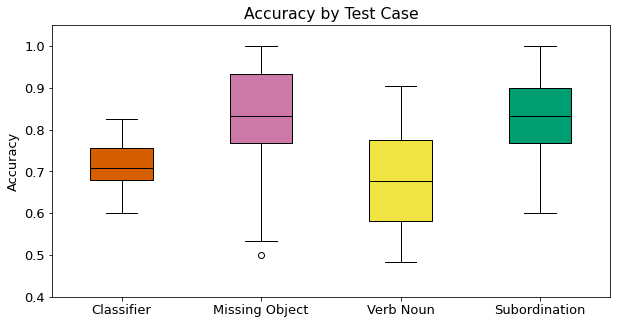

In [491]:
fig, ax = plt.subplots(figsize=(length,width))
labels, data = dic_by_test.keys(), dic_by_test.values()
box = ax.boxplot(data,patch_artist=True)
colors = ['#d55e00', '#cc79a7', '#f0e442', '#009e73']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.setp(box['medians'],color='black')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Test Case')
ax.set_xticklabels(('Classifier', 'Missing Object', 'Verb Noun', 'Subordination'))
plt.ylim((0.4,1.05))

(0.4, 1.05)

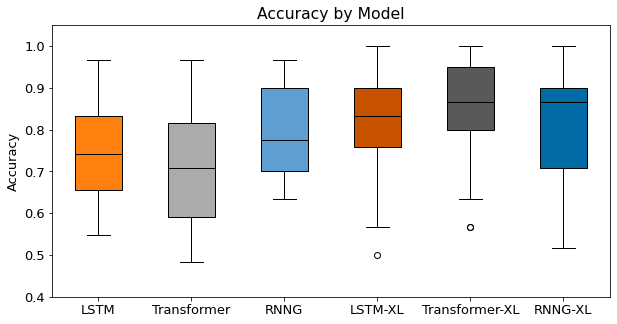

In [494]:
fig, ax = plt.subplots(figsize=(length,width))
labels, data = dic_by_model.keys(), dic_by_model.values()
box = ax.boxplot(data,patch_artist=True)
for patch, color in zip(box['boxes'], cb_safe):
    patch.set_facecolor(color)
plt.setp(box['medians'],color='black')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model')
ax.set_xticklabels(('LSTM', 'Transformer', 'RNNG', 'LSTM-XL', 'Transformer-XL', 'RNNG-XL'))
plt.ylim((0.4,1.05))

In [505]:
dic_by_mt_mean = {i: np.mean(dic_by_mt[i]) for i in dic_by_mt.keys()}
dic_by_mt_sd = {i: np.std(dic_by_mt[i]) for i in dic_by_mt.keys()}

In [506]:
dic_by_mt_sd

{('Classifier', 'LSTM'): 0.06681982407107108,
 ('Classifier', 'Transformer'): 0.013474255287605123,
 ('Classifier', 'RNNG'): 0.0,
 ('Classifier', 'LSTM-XL'): 0.02375336233509318,
 ('Classifier', 'Transformer-XL'): 0.017249798710580782,
 ('Classifier', 'RNNG-XL'): 0.0,
 ('Missing_Object', 'LSTM'): 0.12296576176616163,
 ('Missing_Object', 'Transformer'): 0.12282050538574525,
 ('Missing_Object', 'RNNG'): 0.10103629710818453,
 ('Missing_Object', 'LSTM-XL'): 0.15602607411092909,
 ('Missing_Object', 'Transformer-XL'): 0.15595187608464667,
 ('Missing_Object', 'RNNG-XL'): 0.0687184270936277,
 ('Verb_Noun', 'LSTM'): 0.1132405725573617,
 ('Verb_Noun', 'Transformer'): 0.042588654617620604,
 ('Verb_Noun', 'RNNG'): 0.035152410835005435,
 ('Verb_Noun', 'LSTM-XL'): 0.07107152723872197,
 ('Verb_Noun', 'Transformer-XL'): 0.04808748338709225,
 ('Verb_Noun', 'RNNG-XL'): 0.0734712385414863,
 ('Subordination', 'LSTM'): 0.09389518125260163,
 ('Subordination', 'Transformer'): 0.07216878364870326,
 ('Subordin

In [ ]:
ind = np.arange(4)  # the x locations for the groups
length = 10
width = 6
bar_width = 0.1*(length-4)/width  # the width of the bars
cb_safe = ['#FF800E', '#ABABAB','#5F9ED1', '#C85200', '#595959', '#006BA4']
models_fn = ['LSTM','Transformer','RNNG','LSTM-XL','Transformer-XL','RNNG-XL']
margin = list(range(-width,width+1,2))
margin = [i*1/(width*3) for i in margin]
fig, ax = plt.subplots(figsize=(length,width))
for i in range(6):   
    rects1 = ax.bar(ind[0] + margin[i], dic_by_mt_mean[('Classifier',models_fn[i])], bar_width, yerr=dic_by_mt_sd[('Classifier',models_fn[i])],
                    label=models_fn[i], color=cb_safe[i])
    rects2 = ax.bar(ind[1] + margin[i], dic_by_mt_mean[('Missing_Object',models_fn[i])], bar_width, yerr= dic_by_mt_sd[('Missing_Object',models_fn[i])],
                    color=cb_safe[i])
    rects3 = ax.bar(ind[2] + margin[i], dic_by_mt_mean[('Verb_Noun',models_fn[i])], bar_width, yerr=dic_by_mt_sd[('Verb_Noun',models_fn[i])],
                    color=cb_safe[i])
    rects4 = ax.bar(ind[3] + margin[i], dic_by_mt_mean[('Subordination',models_fn[i])], bar_width, yerr=dic_by_mt_sd[('Subordination',models_fn[i])],
                    color=cb_safe[i])
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Test Case (Averaged Over Modifiers) & Model')
ax.set_xticks(ind)
ax.set_xticklabels(('Classifer','Missing Object','Verb Noun','Subordination'))
ax.legend(loc=(1.05,0.5))
plt.ylim(0.5,1.05)

In [312]:
list(range(-5,6,2))

[-5, -3, -1, 1, 3, 5]

(0.5, 1.0)

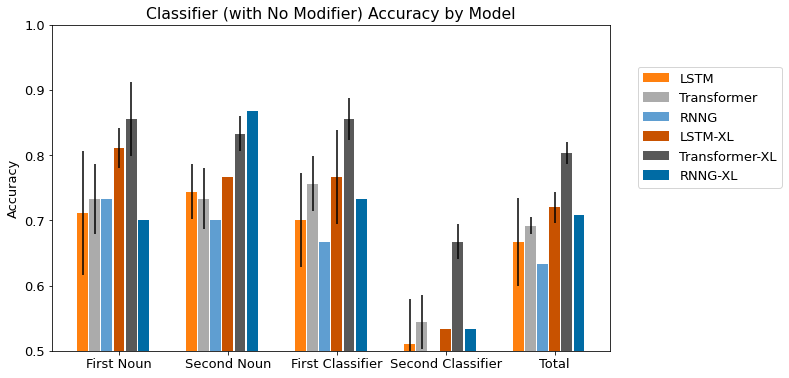

In [384]:
ind = np.arange(5)  # the x locations for the groups
length = 10
width = 6
bar_width = 0.1*(length-4)/width  # the width of the bars
cb_safe = ['#FF800E', '#ABABAB','#5F9ED1', '#C85200', '#595959', '#006BA4']
models_fn = ['LSTM','Transformer','RNNG','LSTM-XL','Transformer-XL','RNNG-XL']
margin = list(range(-width,width+1,2))
margin = [i*1/(width*3) for i in margin]
fig, ax = plt.subplots(figsize=(length,width))
for i in range(6):   
    rects1 = ax.bar(ind + margin[i], df_tables[0].loc[df_tables[0].index[i]][:5], bar_width, yerr=df_tables[0].loc[df_tables[0].index[i]][5:],
                    label=models_fn[i], color=cb_safe[i])
ax.set_ylabel('Accuracy')
ax.set_title('Classifier (with No Modifier) Accuracy by Model')
ax.set_xticks(ind)
ax.set_xticklabels(('First Noun', 'Second Noun', 'First Classifier', 'Second Classifier', 'Total'))
ax.legend(loc=(1.05,0.5))
plt.ylim((0.5,1))

In [365]:
len(df_tables)

13

In [393]:
df_tables[2].loc[df_tables[2].index[0]][1]

0.042

(0.5, 1.05)

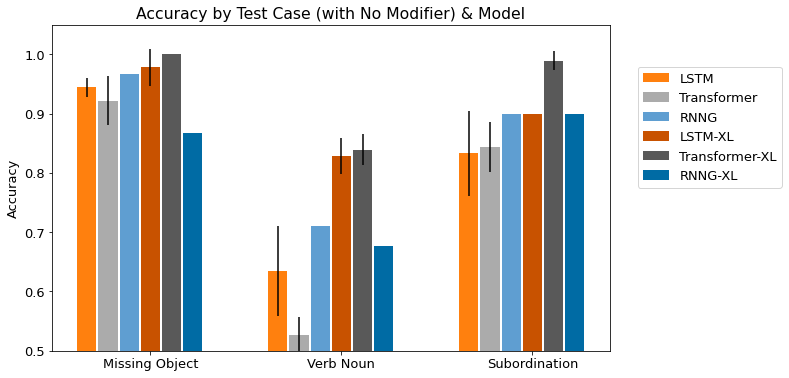

In [401]:
ind = np.arange(3)  # the x locations for the groups
length = 10
width = 6
bar_width = 0.1*(length-4)/width  # the width of the bars
cb_safe = ['#FF800E', '#ABABAB','#5F9ED1', '#C85200', '#595959', '#006BA4']
models_fn = ['LSTM','Transformer','RNNG','LSTM-XL','Transformer-XL','RNNG-XL']
margin = list(range(-width,width+1,2))
margin = [i*1/(width*3) for i in margin]
fig, ax = plt.subplots(figsize=(length,width))
for i in range(6):   
    rects1 = ax.bar(ind[0] + margin[i], df_tables[1].loc[df_tables[1].index[i]][0], bar_width, yerr=df_tables[1].loc[df_tables[1].index[i]][1],
                    label=models_fn[i], color=cb_safe[i])
    rects2 = ax.bar(ind[1] + margin[i], df_tables[5].loc[df_tables[5].index[i]][0], bar_width, yerr=df_tables[5].loc[df_tables[5].index[i]][1],
                    color=cb_safe[i])
    rects3 = ax.bar(ind[2] + margin[i], df_tables[9].loc[df_tables[9].index[i]][0], bar_width, yerr=df_tables[9].loc[df_tables[9].index[i]][1],
                    color=cb_safe[i])
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Test Case (with No Modifier) & Model')
ax.set_xticks(ind)
ax.set_xticklabels(('Missing Object','Verb Noun','Subordination'))
ax.legend(loc=(1.05,0.5))
plt.ylim(0.5,1.05)

In [403]:
df_tables[9]

,Mean Accuracy,Standard Deviation
lstm,0.833,0.072
transformer,0.844,0.042
rnng,0.900,0.000
Xinhua_lstm,0.900,0.000
Xinhua_transformer,0.989,0.016
Xinhua_rnng,0.900,0.000


(0.5, 1.05)

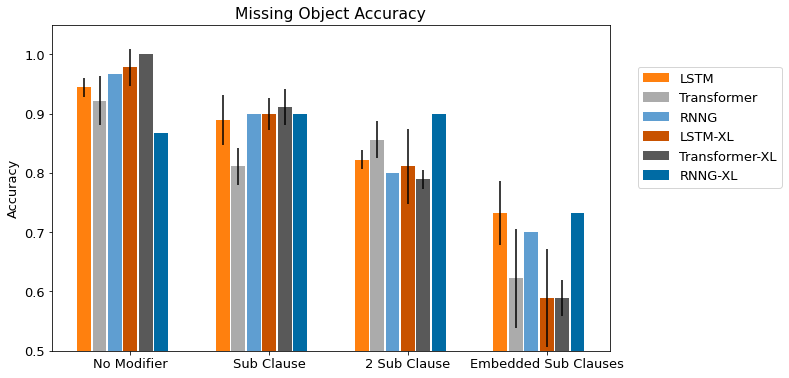

In [406]:
ind = np.arange(4)  # the x locations for the groups
length = 10
width = 6
bar_width = 0.1*(length-4)/width  # the width of the bars
cb_safe = ['#FF800E', '#ABABAB','#5F9ED1', '#C85200', '#595959', '#006BA4']
models_fn = ['LSTM','Transformer','RNNG','LSTM-XL','Transformer-XL','RNNG-XL']
margin = list(range(-width,width+1,2))
margin = [i*1/(width*3) for i in margin]
fig, ax = plt.subplots(figsize=(length,width))
for i in range(6):   
    rects1 = ax.bar(ind[0] + margin[i], df_tables[1].loc[df_tables[1].index[i]][0], bar_width, yerr=df_tables[1].loc[df_tables[1].index[i]][1],
                    label=models_fn[i], color=cb_safe[i])
    rects2 = ax.bar(ind[1] + margin[i], df_tables[2].loc[df_tables[2].index[i]][0], bar_width, yerr=df_tables[2].loc[df_tables[2].index[i]][1],
                    color=cb_safe[i])
    rects3 = ax.bar(ind[2] + margin[i], df_tables[3].loc[df_tables[3].index[i]][0], bar_width, yerr=df_tables[3].loc[df_tables[3].index[i]][1],
                    color=cb_safe[i])
    rects4 = ax.bar(ind[3] + margin[i], df_tables[4].loc[df_tables[4].index[i]][0], bar_width, yerr=df_tables[4].loc[df_tables[4].index[i]][1],
                    color=cb_safe[i])
ax.set_ylabel('Accuracy')
ax.set_title('Missing Object Accuracy')
ax.set_xticks(ind)
ax.set_xticklabels(('No Modifier','Sub Clause','2 Sub Clause','Embedded Sub Clauses'))
ax.legend(loc=(1.05,0.5))
plt.ylim(0.5,1.05)

(0.5, 1.05)

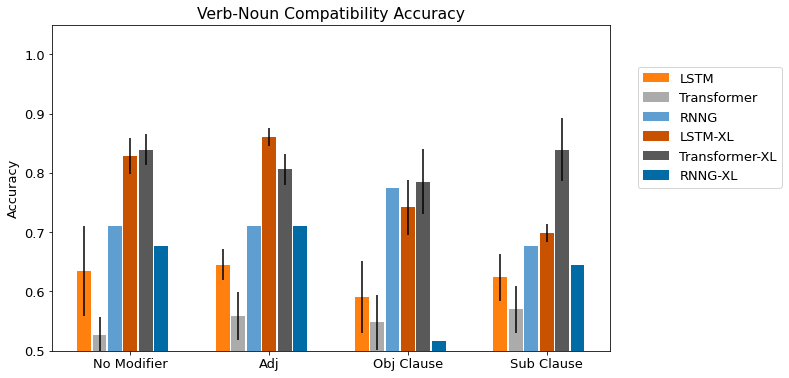

In [407]:
ind = np.arange(4)  # the x locations for the groups
length = 10
width = 6
bar_width = 0.1*(length-4)/width  # the width of the bars
cb_safe = ['#FF800E', '#ABABAB','#5F9ED1', '#C85200', '#595959', '#006BA4']
models_fn = ['LSTM','Transformer','RNNG','LSTM-XL','Transformer-XL','RNNG-XL']
margin = list(range(-width,width+1,2))
margin = [i*1/(width*3) for i in margin]
fig, ax = plt.subplots(figsize=(length,width))
for i in range(6):   
    rects1 = ax.bar(ind[0] + margin[i], df_tables[5].loc[df_tables[5].index[i]][0], bar_width, yerr=df_tables[5].loc[df_tables[5].index[i]][1],
                    label=models_fn[i], color=cb_safe[i])
    rects2 = ax.bar(ind[1] + margin[i], df_tables[6].loc[df_tables[6].index[i]][0], bar_width, yerr=df_tables[6].loc[df_tables[6].index[i]][1],
                    color=cb_safe[i])
    rects3 = ax.bar(ind[2] + margin[i], df_tables[7].loc[df_tables[7].index[i]][0], bar_width, yerr=df_tables[7].loc[df_tables[7].index[i]][1],
                    color=cb_safe[i])
    rects4 = ax.bar(ind[3] + margin[i], df_tables[8].loc[df_tables[8].index[i]][0], bar_width, yerr=df_tables[8].loc[df_tables[8].index[i]][1],
                    color=cb_safe[i])
ax.set_ylabel('Accuracy')
ax.set_title('Verb-Noun Compatibility Accuracy')
ax.set_xticks(ind)
ax.set_xticklabels(('No Modifier','Adj','Obj Clause','Sub Clause'))
ax.legend(loc=(1.05,0.5))
plt.ylim(0.5,1.05)

(0.5, 1.05)

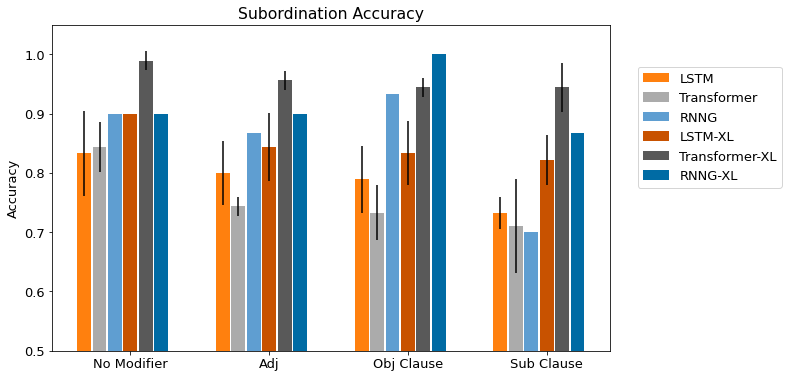

In [408]:
ind = np.arange(4)  # the x locations for the groups
length = 10
width = 6
bar_width = 0.1*(length-4)/width  # the width of the bars
cb_safe = ['#FF800E', '#ABABAB','#5F9ED1', '#C85200', '#595959', '#006BA4']
models_fn = ['LSTM','Transformer','RNNG','LSTM-XL','Transformer-XL','RNNG-XL']
margin = list(range(-width,width+1,2))
margin = [i*1/(width*3) for i in margin]
fig, ax = plt.subplots(figsize=(length,width))
for i in range(6):   
    rects1 = ax.bar(ind[0] + margin[i], df_tables[9].loc[df_tables[9].index[i]][0], bar_width, yerr=df_tables[9].loc[df_tables[9].index[i]][1],
                    label=models_fn[i], color=cb_safe[i])
    rects2 = ax.bar(ind[1] + margin[i], df_tables[10].loc[df_tables[10].index[i]][0], bar_width, yerr=df_tables[10].loc[df_tables[10].index[i]][1],
                    color=cb_safe[i])
    rects3 = ax.bar(ind[2] + margin[i], df_tables[11].loc[df_tables[11].index[i]][0], bar_width, yerr=df_tables[11].loc[df_tables[11].index[i]][1],
                    color=cb_safe[i])
    rects4 = ax.bar(ind[3] + margin[i], df_tables[12].loc[df_tables[12].index[i]][0], bar_width, yerr=df_tables[12].loc[df_tables[12].index[i]][1],
                    color=cb_safe[i])
ax.set_ylabel('Accuracy')
ax.set_title('Subordination Accuracy')
ax.set_xticks(ind)
ax.set_xticklabels(('No Modifier','Adj','Obj Clause','Sub Clause'))
ax.legend(loc=(1.05,0.5))
plt.ylim(0.5,1.05)

In [422]:
df_tables[9]

,Mean Accuracy,Standard Deviation
lstm,0.833,0.072
transformer,0.844,0.042
rnng,0.900,0.000
Xinhua_lstm,0.900,0.000
Xinhua_transformer,0.989,0.016
Xinhua_rnng,0.900,0.000


In [ ]:
ind = np.arange(4)  # the x locations for the groups
length = 10
width = 6
bar_width = 0.1*(length-4)/width  # the width of the bars
cb_safe = ['#FF800E', '#ABABAB','#5F9ED1', '#C85200', '#595959', '#006BA4']
models_fn = ['LSTM','Transformer','RNNG','LSTM-XL','Transformer-XL','RNNG-XL']
margin = list(range(-width,width+1,2))
margin = [i*1/(width*3) for i in margin]
fig, ax = plt.subplots(figsize=(length,width))
for i in range(6):   
    rects1 = ax.bar(ind[0] + margin[i], df_tables[9].loc[df_tables[9].index[i]][0], bar_width, yerr=df_tables[9].loc[df_tables[9].index[i]][1],
                    label=models_fn[i], color=cb_safe[i])
    rects2 = ax.bar(ind[1] + margin[i], df_tables[10].loc[df_tables[10].index[i]][0], bar_width, yerr=df_tables[10].loc[df_tables[10].index[i]][1],
                    color=cb_safe[i])
    rects3 = ax.bar(ind[2] + margin[i], df_tables[11].loc[df_tables[11].index[i]][0], bar_width, yerr=df_tables[11].loc[df_tables[11].index[i]][1],
                    color=cb_safe[i])
    rects4 = ax.bar(ind[3] + margin[i], df_tables[12].loc[df_tables[12].index[i]][0], bar_width, yerr=df_tables[12].loc[df_tables[12].index[i]][1],
                    color=cb_safe[i])
ax.set_ylabel('Accuracy')
ax.set_title('Subordination Accuracy')
ax.set_xticks(ind)
ax.set_xticklabels(('No Modifier','Adj','Obj Clause','Sub Clause'))
ax.legend(loc=(1.05,0.5))
plt.ylim(0.5,1.05)

(0.5, 1.05)

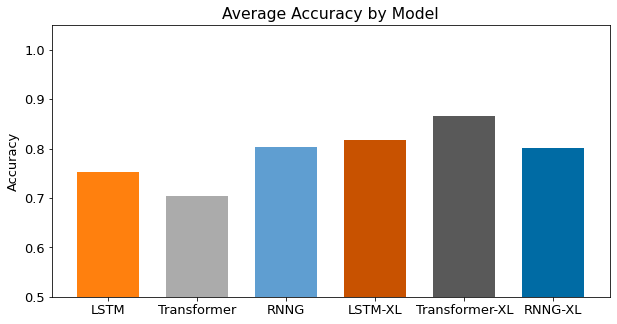

In [493]:
ind = [1.5,2,2.5,3,3.5,4]  # the x locations for the groups
length = 10
width = 5
bar_width = 0.35  # the width of the bars
cb_safe = ['#FF800E', '#ABABAB','#5F9ED1', '#C85200', '#595959', '#006BA4']
models_fn = ['LSTM','Transformer','RNNG','LSTM-XL','Transformer-XL','RNNG-XL']
fig, ax = plt.subplots(figsize=(length,width))
for i in range(6):   
    rects1 = ax.bar(ind[i], acc_by_m[i], bar_width,
                    label=models_fn[i], color=cb_safe[i])
ax.set_ylabel('Accuracy')
ax.set_title('Average Accuracy by Model')
ax.set_xticks(ind)
ax.set_xticklabels(models_fn)
plt.ylim(0.5,1.05)

In [220]:
acc_by_m = np.mean(total_surp,axis=0)
var_by_m = np.mean(total_variance,axis=0)
model_names = ['LSTM','Transformer','RNNG','Xinhua-LSTM','Xinhua-Transformer','Xinhua-RNNG']
for i in range(len(acc_by_m)):
    print('Model Accuracy: ' + model_names[i] + ' ' + str(np.round(acc_by_m[i],3)) + ' ; SD: ' + str(np.round(var_by_m[i],3)))
    print()

Model Accuracy: LSTM 0.753 ; SD: 0.045

Model Accuracy: Transformer 0.704 ; SD: 0.044

Model Accuracy: RNNG 0.803 ; SD: 0.0

Model Accuracy: Xinhua-LSTM 0.817 ; SD: 0.039

Model Accuracy: Xinhua-Transformer 0.866 ; SD: 0.027

Model Accuracy: Xinhua-RNNG 0.801 ; SD: 0.0



In [168]:
evaluate_with_mean()

[0.9333333333333333, 0.9333333333333333, 0.9666666666666667]

In [170]:
evaluate_with_mean(model_path = '../OpenMind/rnng_outputs/',model='rnng')

[0.9666666666666667]

In [638]:
def evaluate(trial = 0, lstm_path = '../OpenMind/lstm_outputs/', large_lstm_path = '../OpenMind/hybridctbv_outputs/', 
             rnng_path = '../OpenMind/rnng_outputs/' , large_rnng_path = '../OpenMind/hybridctbv_outputs_rnng/',
             xlm_path = '../OpenMind/trans_outputs/', large_xlm_path = '../OpenMind/hybrid1_outputs_trans/',
             test = 'Classifier' , modifier = 'none',columns=4, plot=True,annotate=True):
    '''Evaluate the surprisal files for the LSTM, RNNG and Transformer model. Returns a summary table and/or 
        histogram and sentences with annotations.'''
    
    if test == 'Classifier':
        abs_test = 'cls'
    elif test == 'Missing_Object':
        abs_test = 'mobj'
    elif test == 'Verb_Noun':
        abs_test = 'vo'
    elif test == 'Subordination':
        abs_test = 'sd'
    elif test == 'GP_obj':
        abs_test = 'gpo'
    else:
        abs_test = 'gps'
    
    gps_raw = pd.read_table('../syntactic_evaluation/test_suites/GP_sub/gps_' + modifier + '_txt.txt', header=None)
    gps_raw.columns =['content']
    lstm_path = lstm_path + 'trial' + str(trial) + '/'
    rnng_path = rnng_path + 'trial' + str(0) + '/'
    xlm_path = xlm_path + 'trial' + str(0) + '/'

    large_lstm_path = large_lstm_path + 'trial' + str(0) + '/'
    large_rnng_path = large_rnng_path + 'trial' + str(0) + '/'
    large_xlm_path = large_xlm_path + 'trial' + str(0) + '/'

    
    surp_lstm = pd.read_csv(lstm_path + 'surprisals_' + abs_test + '_' + modifier + '.tsv', sep='\t', header=0)
    surp_large_lstm = pd.read_csv(large_lstm_path + 'surprisals_' + abs_test + '_' + modifier + '.tsv', sep='\t', header=0)
    surp_rnng = pd.read_table(rnng_path + 'surprisals_output_' + abs_test + '_' + modifier + '.txt', header=0)
    surp_large_rnng = pd.read_table(large_rnng_path + 'surprisals_output_' + abs_test + '_' + modifier + '.txt', header=0)
    surp_xlm = pd.read_table(xlm_path + 'surprisals_output_' + abs_test + '_' + modifier + '.txt', header=0)
    surp_large_xlm = pd.read_table(large_xlm_path + 'surprisals_output_' + abs_test + '_' + modifier + '.txt', header=0)
    
    sent = pd.read_table("test_suites/" + test + "/" + abs_test + "_" + modifier + "_txt.txt",header=None)

    assert len(surp_lstm) == len(surp_rnng) == len(surp_xlm) == len(surp_large_xlm) == len(surp_large_lstm) == len(surp_large_rnng)
    
    if columns == 4:
        if test == 'Classifier':
            df_lstm = pd.DataFrame(data=surprisal_by_tests(surp_lstm),columns=['G1','U1','G2','U2'])
            df_rnng = pd.DataFrame(data=surprisal_by_tests(surp_rnng),columns=['G1','U1','G2','U2'])
            df_xlm = pd.DataFrame(data=surprisal_by_tests(surp_xlm),columns=['G1','U1','G2','U2'])
            df_large_lstm = pd.DataFrame(data=surprisal_by_tests(surp_large_lstm),columns=['G1','U1','G2','U2'])
            df_large_rnng = pd.DataFrame(data=surprisal_by_tests(surp_large_rnng),columns=['G1','U1','G2','U2'])
            df_large_xlm = pd.DataFrame(data=surprisal_by_tests(surp_large_xlm),columns=['G1','U1','G2','U2'])
                       
        # calculate difference between ungrammatical and grammatical sentences
        
        lstm_list = compute_diff(df_lstm)
        rnng_list = compute_diff(df_rnng)
        xlm_list = compute_diff(df_xlm)
        
        large_lstm_list = compute_diff(df_large_lstm)
        large_rnng_list = compute_diff(df_large_rnng)
        large_xlm_list = compute_diff(df_large_xlm)
        
        models = [lstm_list,rnng_list,xlm_list,large_lstm_list,large_rnng_list,large_xlm_list]
        model_total = compute_cls_mean(models)
        lstm_total,rnng_total,xlm_total,large_lstm_total,large_rnng_total,large_xlm_total = model_total

        
        data = [[np.round(calc_accuracy(lstm_list[0]),3),np.round(calc_accuracy(lstm_list[1]),3),np.round(calc_accuracy(lstm_list[2]),3),np.round(calc_accuracy(lstm_list[3]),3),np.round(lstm_total,3)],
               [np.round(calc_accuracy(xlm_list[0]),3),np.round(calc_accuracy(xlm_list[1]),3),np.round(calc_accuracy(xlm_list[2]),3),np.round(calc_accuracy(xlm_list[3]),3),np.round(xlm_total,3)],
               [np.round(calc_accuracy(rnng_list[0]),3),np.round(calc_accuracy(rnng_list[1]),3),np.round(calc_accuracy(rnng_list[2]),3),np.round(calc_accuracy(rnng_list[3]),3),np.round(rnng_total,3)],
               [np.round(calc_accuracy(large_lstm_list[0]),3),np.round(calc_accuracy(large_lstm_list[1]),3),np.round(calc_accuracy(large_lstm_list[2]),3),np.round(calc_accuracy(large_lstm_list[3]),3),np.round(large_lstm_total,3)],
               [np.round(calc_accuracy(large_xlm_list[0]),3),np.round(calc_accuracy(large_xlm_list[1]),3),np.round(calc_accuracy(large_xlm_list[2]),3),np.round(calc_accuracy(large_xlm_list[3]),3),np.round(large_xlm_total,3)],
               [np.round(calc_accuracy(large_rnng_list[0]),3),np.round(calc_accuracy(large_rnng_list[1]),3),np.round(calc_accuracy(large_rnng_list[2]),3),np.round(calc_accuracy(large_rnng_list[3]),3),np.round(large_rnng_total,3)]]
        table = pd.DataFrame(data)
        table.index = ['lstm','xlm','rnng','Xinhua_lstm','Xinhua_xlm','Xinhua_rnng']
        table.columns = ['First noun', 'Second noun', 'First classifier', 'Second classifier', 'Total']
#         print(table)
        
        if plot:
            cls_plot(lstm_list[0],lstm_list[1],lstm_list[2],lstm_list[3],model='LSTM')
            cls_plot(rnng_list[0],rnng_list[1],rnng_list[2],rnng_list[3],model='RNNG')
            cls_plot(xlm_list[0],xlm_list[1],xlm_list[2],xlm_list[3],model='Transformer')
            cls_plot(large_lstm_list[0],large_lstm_list[1],large_lstm_list[2],large_lstm_list[3],model='Xinhua LSTM')
            cls_plot(large_rnng_list[0],large_rnng_list[1],large_rnng_list[2],large_rnng_list[3],model='Xinhua RNNG')
            cls_plot(large_xlm_list[0],large_xlm_list[1],large_xlm_list[2],large_xlm_list[3],model='Xinhua Transformer')
            
        if annotate:
#             if test == 'Classifier':
            for i in range(len(lstm_list[0])):
                print(i)
#                 print('1: ', sent.loc[i*4].values[0], 'Freq:', dict_freq[sent.loc[i*4].values[0].split(' ')[-2]], '; LSTM: ', round(df_lstm['G1'].loc[i],3),'; Transformer: ',  round(df_xlm['G1'].loc[i],3), '; RNNG: ',  round(df_rnng['G1'].loc[i],3), 
#                       '; Xinhua LSTM: ', round(df_large_lstm['G1'].loc[i],3), '; Xinhua Transformer: ', round(df_large_xlm['G1'].loc[i],3), '; Xinhua RNNG: ', round(df_large_rnng['G1'].loc[i],3),
#                       '\n2: ', sent.loc[1+i*4].values[0],'Freq:', dict_freq[sent.loc[1+i*4].values[0].split(' ')[-2]], '; LSTM: ', round(df_lstm['U1'].loc[i],3),'; Transformer: ',  round(df_xlm['G1'].loc[i],3), '; RNNG: ',  round(df_rnng['U1'].loc[i],3), 
#                       '; Xinhua LSTM: ', round(df_large_lstm['U1'].loc[i],3), '; Xinhua Transformer: ', round(df_large_xlm['U1'].loc[i],3),'; Xinhua RNNG: ', round(df_large_rnng['U1'].loc[i],3),
#                       '\n3: ',sent.loc[2+i*4].values[0], 'Freq:', dict_freq[sent.loc[2+i*4].values[0].split(' ')[-2]],'; LSTM: ', round(df_lstm['G2'].loc[i],3), '; Tranformer: ',  round(df_xlm['G1'].loc[i],3), '; RNNG: ', round(df_rnng['G2'].loc[i],3), 
#                       '; Xinhua LSTM: ', round(df_large_lstm['G2'].loc[i],3), '; Xinhua Transformer: ', round(df_large_xlm['G2'].loc[i],3),'; Xinhua RNNG: ', round(df_large_rnng['G2'].loc[i],3),
#                       '\n4: ',sent.loc[3+i*4].values[0], 'Freq:', dict_freq[sent.loc[3+i*4].values[0].split(' ')[-2]],'; LSTM: ', round(df_lstm['U2'].loc[i],3), '; Transformer: ',  round(df_xlm['G1'].loc[i],3), '; RNNG: ', round(df_rnng['U2'].loc[i],3), 
#                       '; Xinhua LSTM: ', round(df_large_lstm['U2'].loc[i],3),'; Xinhua Transformer: ', round(df_large_xlm['U2'].loc[i],3),'; Xinhua RNNG: ', round(df_large_rnng['U2'].loc[i],3))
                print('1: ', sent.loc[i*4].values[0], '; LSTM: ', round(df_lstm['G1'].loc[i],3),'; Transformer: ',  round(df_xlm['G1'].loc[i],3), '; RNNG: ',  round(df_rnng['G1'].loc[i],3), 
                      '; Xinhua LSTM: ', round(df_large_lstm['G1'].loc[i],3), '; Xinhua Transformer: ', round(df_large_xlm['G1'].loc[i],3), '; Xinhua RNNG: ', round(df_large_rnng['G1'].loc[i],3),
                      '\n2: ', sent.loc[1+i*4].values[0], '; LSTM: ', round(df_lstm['U1'].loc[i],3),'; Transformer: ',  round(df_xlm['G1'].loc[i],3), '; RNNG: ',  round(df_rnng['U1'].loc[i],3), 
                      '; Xinhua LSTM: ', round(df_large_lstm['U1'].loc[i],3), '; Xinhua Transformer: ', round(df_large_xlm['U1'].loc[i],3),'; Xinhua RNNG: ', round(df_large_rnng['U1'].loc[i],3),
                      '\n3: ',sent.loc[2+i*4].values[0], '; LSTM: ', round(df_lstm['G2'].loc[i],3), '; Tranformer: ',  round(df_xlm['G1'].loc[i],3), '; RNNG: ', round(df_rnng['G2'].loc[i],3), 
                      '; Xinhua LSTM: ', round(df_large_lstm['G2'].loc[i],3), '; Xinhua Transformer: ', round(df_large_xlm['G2'].loc[i],3),'; Xinhua RNNG: ', round(df_large_rnng['G2'].loc[i],3),
                      '\n4: ',sent.loc[3+i*4].values[0], '; LSTM: ', round(df_lstm['U2'].loc[i],3), '; Transformer: ',  round(df_xlm['G1'].loc[i],3), '; RNNG: ', round(df_rnng['U2'].loc[i],3), 
                      '; Xinhua LSTM: ', round(df_large_lstm['U2'].loc[i],3),'; Xinhua Transformer: ', round(df_large_xlm['U2'].loc[i],3),'; Xinhua RNNG: ', round(df_large_rnng['U2'].loc[i],3))
                print('2 - 1: ', 'LSTM: ', round(lstm_list[0][i],3), '; Transformer: ', round(xlm_list[0][i],3),'; RNNG: ', round(rnng_list[0][i],3),  
                      '; Xinhua LSTM: ', round(large_lstm_list[0][i],3), '; Xinhua Transformer: ', round(large_xlm_list[0][i],3), '; Xinhua RNNG: ', round(large_rnng_list[0][i],3))
                print('4 - 3: ', 'LSTM: ', round(lstm_list[1][i],3),  '; Transformer: ', round(xlm_list[1][i],3),'; RNNG: ', round(rnng_list[1][i],3),
                      '; Xinhua LSTM: ', round(large_lstm_list[1][i],3),'; Xinhua Transformer: ', round(large_xlm_list[1][i],3),'; Xinhua RNNG: ', round(large_rnng_list[1][i],3))
                print('4 - 1: ', 'LSTM: ', round(lstm_list[2][i],3),'; Transformer: ', round(xlm_list[2][i],3), '; RNNG: ', round(rnng_list[2][i],3),
                      '; Xinhua LSTM: ', round(large_lstm_list[2][i],3),'; Xinhua Transformer: ', round(large_xlm_list[2][i],3),'; Xinhua RNNG: ', round(large_rnng_list[2][i],3))
                print('2 - 3: ', 'LSTM: ', round(lstm_list[3][i],3), '; Transformer: ', round(xlm_list[3][i],3), '; RNNG: ', round(rnng_list[3][i],3),
                      '; Xinhua LSTM: ', round(large_lstm_list[3][i],3),'; Xinhua Transformer: ', round(large_xlm_list[3][i],3),'; Xinhuaews RNNG: ', round(large_rnng_list[3][i],3))
                print('\n')

   
    elif columns == 2:
        if test == 'Missing_Object':
            df_lstm = pd.DataFrame(data=surprisal_by_tests(surp_lstm,columns=2,target=-1),columns=['U','G'])
            df_rnng = pd.DataFrame(data=surprisal_by_tests(surp_rnng,columns=2,target=-1),columns=['U','G'])
            df_xlm = pd.DataFrame(data=surprisal_by_tests(surp_xlm,columns=2,target=-1),columns=['U','G'])
            df_large_lstm = pd.DataFrame(data=surprisal_by_tests(surp_large_lstm,columns=2,target=-1),columns=['U','G'])
            df_large_rnng = pd.DataFrame(data=surprisal_by_tests(surp_large_rnng,columns=2,target=-1),columns=['U','G'])
            df_large_xlm = pd.DataFrame(data=surprisal_by_tests(surp_large_xlm,columns=2,target=-1),columns=['U','G'])
        elif  test == 'Verb_Noun':
            df_lstm = pd.DataFrame(data=surprisal_by_tests(surp_lstm,columns=2,target=-2),columns=['G','U'])
            df_rnng = pd.DataFrame(data=surprisal_by_tests(surp_rnng,columns=2,target=-2),columns=['G','U'])
            df_xlm = pd.DataFrame(data=surprisal_by_tests(surp_xlm,columns=2,target=-2),columns=['G','U'])
            df_large_lstm = pd.DataFrame(data=surprisal_by_tests(surp_large_lstm,columns=2,target=-2),columns=['G','U'])
            df_large_rnng = pd.DataFrame(data=surprisal_by_tests(surp_large_rnng,columns=2,target=-2),columns=['G','U'])
            df_large_xlm = pd.DataFrame(data=surprisal_by_tests(surp_large_xlm,columns=2,target=-2),columns=['G','U'])
        elif  test == 'Subordination':
            df_lstm = pd.DataFrame(data=surprisal_by_tests(surp_lstm,columns=2,target=-1),columns=['G','U'])
            df_rnng = pd.DataFrame(data=surprisal_by_tests(surp_rnng,columns=2,target=-1),columns=['G','U'])
            df_xlm = pd.DataFrame(data=surprisal_by_tests(surp_xlm,columns=2,target=-1),columns=['G','U'])
            df_large_lstm = pd.DataFrame(data=surprisal_by_tests(surp_large_lstm,columns=2,target=-1),columns=['G','U'])
            df_large_rnng = pd.DataFrame(data=surprisal_by_tests(surp_large_rnng,columns=2,target=-1),columns=['G','U'])
            df_large_xlm = pd.DataFrame(data=surprisal_by_tests(surp_large_xlm,columns=2,target=-1),columns=['G','U'])
        elif test == 'GP_obj':
            df_lstm = pd.DataFrame(data=surprisal_by_tests(surp_lstm,columns=2,target=-4),columns=['G','U'])
            df_rnng = pd.DataFrame(data=surprisal_by_tests(surp_rnng,columns=2,target=-4),columns=['G','U'])
            df_xlm = pd.DataFrame(data=surprisal_by_tests(surp_xlm,columns=2,target=-4),columns=['G','U'])
            df_large_lstm = pd.DataFrame(data=surprisal_by_tests(surp_large_lstm,columns=2,target=-4),columns=['G','U'])
            df_large_rnng = pd.DataFrame(data=surprisal_by_tests(surp_large_rnng,columns=2,target=-4),columns=['G','U'])
            df_large_xlm = pd.DataFrame(data=surprisal_by_tests(surp_large_xlm,columns=2,target=-4),columns=['G','U'])
            
        elif test == 'GP_sub':
            df_lstm = pd.DataFrame(data=surprisal_by_tests(surp_lstm,columns=2,search=True,raw=gps_raw),columns=['G','U'])
            df_rnng = pd.DataFrame(data=surprisal_by_tests(surp_rnng,columns=2,search=True,raw=gps_raw),columns=['G','U'])
            df_xlm = pd.DataFrame(data=surprisal_by_tests(surp_xlm,columns=2,search=True,raw=gps_raw),columns=['G','U'])
            df_large_lstm = pd.DataFrame(data=surprisal_by_tests(surp_large_lstm,columns=2,search=True,raw=gps_raw),columns=['G','U'])
            df_large_rnng = pd.DataFrame(data=surprisal_by_tests(surp_large_rnng,columns=2,search=True,raw=gps_raw),columns=['G','U'])
            df_large_xlm = pd.DataFrame(data=surprisal_by_tests(surp_large_xlm,columns=2,search=True,raw=gps_raw),columns=['G','U'])
 
        diff_lstm = df_lstm['U'] - df_lstm['G'] 
        diff_rnng = df_rnng['U'] - df_rnng['G']
        diff_xlm = df_xlm['U'] - df_xlm['G']
        diff_large_lstm = df_large_lstm['U'] - df_large_lstm['G'] 
        diff_large_rnng = df_large_rnng['U'] - df_large_rnng['G'] 
        diff_large_xlm = df_large_xlm['U'] - df_large_xlm['G'] 
        
        lstm = calc_accuracy(diff_lstm)
        rnng = calc_accuracy(diff_rnng)
        xlm = calc_accuracy(diff_xlm)
        large_lstm = calc_accuracy(diff_large_lstm)
        large_rnng = calc_accuracy(diff_large_rnng)
        large_xlm = calc_accuracy(diff_large_xlm)
        
        data = [[np.round(lstm,3)],
               [np.round(xlm,3)],
               [np.round(rnng,3)],
               [np.round(large_lstm,3)],
               [np.round(large_xlm,3)],
               [np.round(large_rnng,3)]]
        
        table = pd.DataFrame(data)
        table.index = ['lstm','transformer','rnng','Xinhua_lstm','Xinhua_transformer','Xinhua_rnng']
        table.columns = ['Ratio']
#         print(table)
#         print('\n')
        
        if plot:
            fig, ax = plt.subplots(2,3,figsize=(10,8))
            ax[0][0].hist(diff_lstm,alpha= 0.8,bins=30,edgecolor='white')
            ax[0][0].set_title('LSTM ' + test + ' - ' + modifier + ' U - G')
            ax[0][1].hist(diff_rnng,alpha= 0.8,bins=30,edgecolor='white')
            ax[0][1].set_title('Transformer ' + test + ' - ' + modifier + ' U - G')
            ax[0][2].hist(diff_rnng,alpha= 0.8,bins=30,edgecolor='white')
            ax[0][2].set_title('RNNG ' + test + ' - ' + modifier + ' U - G')
            ax[1][0].hist(diff_large_lstm,alpha= 0.8,bins=30,edgecolor='white')
            ax[1][0].set_title('Xinhua LSTM ' + test + ' - ' + modifier + ' U - G')
            ax[1][1].hist(diff_large_xlm,alpha= 0.8,bins=30,edgecolor='white')
            ax[1][1].set_title('Xinhua Transformer ' + test + ' - ' + modifier + ' U - G')
            ax[1][2].hist(diff_large_rnng,alpha= 0.8,bins=30,edgecolor='white')
            ax[1][2].set_title('Xinhua RNNG ' + test + ' - ' + modifier + ' U - G')
            fig.suptitle('Histogram ' + test)
            
        if annotate:
            for i in range(len(diff_lstm)):
                print(i)
                if test == 'Missing_Object':
                    print('1: ', sent.loc[i*2].values[0], 'LSTM: ',round(df_lstm['U'].loc[i],3),'; Transformer:',round(df_xlm['U'].loc[i],3),'; RNNG:',round(df_rnng['U'].loc[i],3), '; Xinhua LSTM: ',round(df_large_lstm['U'].loc[i],3), '; Xinhua Transformer: ',round(df_large_xlm['U'].loc[i],3),'; Xinhua RNNG: ',round(df_large_rnng['U'].loc[i],3),
                      '\n2: ', sent.loc[1+i*2].values[0],'LSTM: ', round(df_lstm['G'].loc[i],3),'; Transformer:',round(df_xlm['G'].loc[i],3),'; RNNG:',round(df_rnng['G'].loc[i],3), '; Xinhua LSTM: ', round(df_large_lstm['G'].loc[i],3),'; Xinhua Transformer: ',round(df_large_xlm['G'].loc[i],3),'; Xinhua RNNG: ', round(df_large_rnng['G'].loc[i],3))
                else:
                    print('1: ', sent.loc[i*2].values[0], 'LSTM: ',round(df_lstm['G'].loc[i],3),'; Transformer:',round(df_xlm['G'].loc[i],3),'; RNNG:',round(df_rnng['G'].loc[i],3), '; Xinhua LSTM: ',round(df_large_lstm['G'].loc[i],3),'; Xinhua Transformer: ',round(df_large_xlm['G'].loc[i],3), '; Xinhua RNNG: ',round(df_large_rnng['G'].loc[i],3),
                      '\n2: ', sent.loc[1+i*2].values[0],'LSTM: ', round(df_lstm['U'].loc[i],3),'; Transformer:',round(df_xlm['U'].loc[i],3),'; RNNG:',round(df_rnng['U'].loc[i],3), '; Xinhua LSTM: ', round(df_large_lstm['U'].loc[i],3), '; Xinhua Transformer: ',round(df_large_xlm['U'].loc[i],3), '; Xinhua RNNG: ', round(df_large_rnng['U'].loc[i],3))
                print('U - G: ', 'LSTM: ', round(diff_lstm[i],3),'; Transformer: ', round(diff_xlm[i],3),'; RNNG: ', round(diff_rnng[i],3), '; Xinhua LSTM: ', round(diff_large_lstm[i],3),'; Xinhua Transformer: ', round(diff_large_xlm[i],3), '; Xinhua RNNG: ', round(diff_large_rnng[i],3))
                print('\n')
        
    return table
        

In [654]:
def surprisal_by_tests(df,columns=4,target=-2,search=False,raw=None):
    total = []
    for suites in range(int(max(df['sentence_id'])/columns)):
        surprisal = []
        for sent in range(1+suites*columns,1+(1+suites)*columns):
            temp = df.loc[df['sentence_id']==sent]
            max_token = temp.token_id.values[-1]
            if not search:
                if target == -2:
                    surp_noun = temp.loc[temp['token_id']==max_token].surprisal.values + temp.loc[temp['token_id']==(max_token-1)].surprisal.values
                elif target == -1:
                    surp_noun = temp.loc[temp['token_id']==max_token].surprisal.values
                elif target == -4:
                    target_token = temp.token_id.values[target]
                    surp_noun = temp.loc[temp['token_id']==target_token].surprisal.values
            else:
                assert raw is not None
                check = raw['content'].loc[sent-1].split(' ')
                target_token = [i for (i,v) in enumerate(check) if v == '的'][-1]+1
#                 print(temp.loc[temp['token_id']==target_token])
                surp_noun = temp.loc[temp['token_id']==target_token].surprisal.values
            surprisal.append(surp_noun[0])
        total.append(surprisal)
    return total


In [21]:
def calc_accuracy(data):
    '''Calculate the proportion of the test suites that the model predicts as expected'''
    return sum(data>0)/len(data)

In [23]:
df_freq = pd.read_csv('../cls_noun_freq.csv',header=0)

In [24]:
df_freq=df_freq.set_index('noun')
dict_freq = df_freq.to_dict(orient='dict')
dict_freq = dict_freq['freq']

In [44]:
def calc_averate(num, case, mod):
    if case == 'Classifier':
        col = 4
    else:
        col = 2
    accuracy = []
    for i in range(num):
        table = evaluate(trial = i, test = case , modifier = mod, columns=col, annotate=False,plot=False)
        accuracy.append(table['Total'])
    print('Trial average: ',np.mean(accuracy,axis=1))
    return np.mean(accuracy,axis=0)

In [47]:
calc_averate(3,'Classifier','none')

            First noun  Second noun  First classifier  Second classifier  \
lstm             0.833        0.800             0.800              0.600   
rnng             0.733        0.700             0.667              0.433   
large_lstm       0.767        0.767             0.700              0.533   
large_rnng       0.833        0.833             0.733              0.600   

            Total  
lstm        0.758  
rnng        0.633  
large_lstm  0.692  
large_rnng  0.750  
            First noun  Second noun  First classifier  Second classifier  \
lstm             0.600        0.733             0.633              0.433   
rnng             0.733        0.700             0.667              0.433   
large_lstm       0.767        0.767             0.700              0.533   
large_rnng       0.833        0.833             0.733              0.600   

            Total  
lstm        0.600  
rnng        0.633  
large_lstm  0.692  
large_rnng  0.750  
            First noun  Second noun  F

array([0.66666667, 0.633     , 0.692     , 0.75      ])

------
### CTB & Hybrid Xinhua Data with CTB
------

In [80]:
large_lstm_path = '../OpenMind/hybrid1_outputs/'
large_rnng_path = '../OpenMind/hybrid1_outputs_rnng/'

In [130]:
evaluate(test = 'Classifier' , modifier = 'none', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path, columns=4,annotate=False,plot=False)

,First noun,Second noun,First classifier,Second classifier,Total
lstm,0.833,0.800,0.800,0.600,0.758
xlm,0.667,0.700,0.800,0.600,0.692
rnng,0.733,0.700,0.667,0.433,0.633
Xinhua_lstm,0.767,0.767,0.700,0.533,0.692
Xinhua_xlm,0.933,0.833,0.900,0.633,0.825
Xinhua_rnng,0.700,0.867,0.733,0.533,0.708


In [639]:
evaluate(test = 'Classifier' , modifier = 'adj', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path, columns=4,annotate=False,plot=False)

,First noun,Second noun,First classifier,Second classifier,Total
lstm,0.667,0.600,0.700,0.367,0.583
xlm,0.567,0.767,0.600,0.500,0.608
rnng,0.700,0.733,0.767,0.333,0.633
Xinhua_lstm,0.733,0.800,0.733,0.433,0.675
Xinhua_xlm,0.900,0.733,0.867,0.533,0.758
Xinhua_rnng,0.700,0.700,0.667,0.467,0.633


In [640]:
evaluate(test = 'Classifier' , modifier = 'obj', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path, columns=4,annotate=False,plot=False)

,First noun,Second noun,First classifier,Second classifier,Total
lstm,0.600,0.500,0.633,0.400,0.533
xlm,0.633,0.733,0.700,0.400,0.617
rnng,0.733,0.733,0.700,0.333,0.625
Xinhua_lstm,0.633,0.700,0.600,0.467,0.600
Xinhua_xlm,0.733,0.833,0.767,0.467,0.700
Xinhua_rnng,0.633,0.733,0.667,0.433,0.617


In [641]:
evaluate(test = 'Classifier' , modifier = 'sub', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path, columns=4,annotate=False,plot=False)

,First noun,Second noun,First classifier,Second classifier,Total
lstm,0.633,0.667,0.533,0.533,0.592
xlm,0.567,0.733,0.633,0.400,0.583
rnng,0.733,0.533,0.600,0.400,0.567
Xinhua_lstm,0.700,0.700,0.633,0.433,0.617
Xinhua_xlm,0.867,0.733,0.733,0.467,0.700
Xinhua_rnng,0.667,0.633,0.700,0.400,0.600


In [658]:
evaluate(test = 'GP_obj' , modifier = 'none', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path, columns=2,annotate=False,plot=False)


,Ratio
lstm,0.484
transformer,0.677
rnng,0.742
Xinhua_lstm,0.742
Xinhua_transformer,0.839
Xinhua_rnng,0.774


In [643]:
evaluate(test = 'GP_obj' , modifier = 'adj', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path, columns=2,annotate=False,plot=False)


,Ratio
lstm,0.581
transformer,0.742
rnng,0.677
Xinhua_lstm,0.710
Xinhua_transformer,0.806
Xinhua_rnng,0.806


In [644]:
evaluate(test = 'GP_obj' , modifier = 'obj', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path, columns=2,annotate=False,plot=False)


,Ratio
lstm,0.548
transformer,0.645
rnng,0.645
Xinhua_lstm,0.742
Xinhua_transformer,0.742
Xinhua_rnng,0.645


In [645]:
evaluate(test = 'GP_obj' , modifier = 'sub', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path, columns=2,annotate=False,plot=False)


,Ratio
lstm,0.613
transformer,0.645
rnng,0.613
Xinhua_lstm,0.645
Xinhua_transformer,0.806
Xinhua_rnng,0.742


In [655]:
evaluate(test = 'GP_sub' , modifier = 'none', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path, columns=2,annotate=False,plot=False)

,Ratio
lstm,0.226
transformer,0.355
rnng,0.645
Xinhua_lstm,0.452
Xinhua_transformer,0.516
Xinhua_rnng,0.613


In [647]:
evaluate(test = 'GP_sub' , modifier = 'adj', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path, columns=2,annotate=False,plot=False)

,Ratio
lstm,0.097
transformer,0.226
rnng,0.355
Xinhua_lstm,0.323
Xinhua_transformer,0.290
Xinhua_rnng,0.323


In [648]:
evaluate(test = 'GP_sub' , modifier = 'obj', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path, columns=2,annotate=False,plot=False)

,Ratio
lstm,0.194
transformer,0.290
rnng,0.323
Xinhua_lstm,0.355
Xinhua_transformer,0.387
Xinhua_rnng,0.387


In [656]:
evaluate(test = 'GP_sub' , modifier = 'sub', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path, columns=2,annotate=False,plot=False)

,Ratio
lstm,0.129
transformer,0.258
rnng,0.258
Xinhua_lstm,0.419
Xinhua_transformer,0.323
Xinhua_rnng,0.581


In [185]:
evaluate(test = 'Missing_Object' , modifier = 'none', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path,columns=2,annotate=False,plot=False)

,Ratio
lstm,0.933
transformer,0.967
rnng,0.967
Xinhua_lstm,1.000
Xinhua_transformer,1.000
Xinhua_rnng,0.867


In [186]:
evaluate(test = 'Missing_Object' , modifier = 'sub', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path,columns=2,annotate=False,plot=False)

,Ratio
lstm,0.833
transformer,0.767
rnng,0.900
Xinhua_lstm,0.867
Xinhua_transformer,0.933
Xinhua_rnng,0.900


In [187]:
evaluate(test = 'Missing_Object' , modifier = 'sub2', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path,columns=2,annotate=False,plot=False)

,Ratio
lstm,0.800
transformer,0.833
rnng,0.800
Xinhua_lstm,0.900
Xinhua_transformer,0.800
Xinhua_rnng,0.900


In [188]:
evaluate(test = 'Missing_Object' , modifier = 'subh', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path,columns=2,annotate=False,plot=False)

,Ratio
lstm,0.667
transformer,0.600
rnng,0.700
Xinhua_lstm,0.700
Xinhua_transformer,0.633
Xinhua_rnng,0.733


In [189]:
evaluate(test = 'Verb_Noun' , modifier = 'none',columns=2, large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path,annotate=False,plot=False)

,Ratio
lstm,0.742
transformer,0.548
rnng,0.710
Xinhua_lstm,0.806
Xinhua_transformer,0.839
Xinhua_rnng,0.677


In [190]:
evaluate(test = 'Verb_Noun' , modifier = 'adj', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path,columns=2,annotate=False,plot=False)

,Ratio
lstm,0.645
transformer,0.613
rnng,0.710
Xinhua_lstm,0.871
Xinhua_transformer,0.774
Xinhua_rnng,0.710


In [191]:
evaluate(test = 'Verb_Noun' , modifier = 'obj', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path,columns=2,annotate=False,plot=False)

,Ratio
lstm,0.677
transformer,0.613
rnng,0.774
Xinhua_lstm,0.774
Xinhua_transformer,0.710
Xinhua_rnng,0.516


In [192]:
evaluate(test = 'Verb_Noun' , modifier = 'sub', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path,columns=2,annotate=False,plot=False)

,Ratio
lstm,0.613
transformer,0.613
rnng,0.677
Xinhua_lstm,0.710
Xinhua_transformer,0.774
Xinhua_rnng,0.645


In [195]:
evaluate(test = 'Subordination' , modifier = 'none', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path,columns=2,annotate=False,plot=False)

,Ratio
lstm,0.8
transformer,0.8
rnng,0.9
Xinhua_lstm,0.9
Xinhua_transformer,1.0
Xinhua_rnng,0.9


In [194]:
evaluate(test = 'Subordination' , modifier = 'adj', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path,columns=2,annotate=False,plot=False)

,Ratio
lstm,0.800
transformer,0.733
rnng,0.867
Xinhua_lstm,0.867
Xinhua_transformer,0.967
Xinhua_rnng,0.900


In [196]:
evaluate(test = 'Subordination' , modifier = 'obj', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path,columns=2,annotate=False,plot=False)

,Ratio
lstm,0.767
transformer,0.700
rnng,0.933
Xinhua_lstm,0.833
Xinhua_transformer,0.933
Xinhua_rnng,1.000


In [197]:
evaluate(test = 'Subordination' , modifier = 'sub', large_lstm_path=large_lstm_path, large_rnng_path=large_rnng_path,columns=2,annotate=False,plot=False)

,Ratio
lstm,0.733
transformer,0.600
rnng,0.700
Xinhua_lstm,0.867
Xinhua_transformer,0.900
Xinhua_rnng,0.867


------
### CTB & Hybrid Xinhua Data with CTB Validation Set
------

In [64]:
evaluate(test = 'Classifier' , modifier = 'none',columns=4,annotate=False,plot=False)

            First noun  Second noun  First classifier  Second classifier  \
lstm             0.833        0.800             0.800              0.600   
rnng             0.733        0.700             0.667              0.433   
large_lstm       0.867        0.733             0.767              0.633   
large_rnng       0.733        0.667             0.733              0.600   

            Total  
lstm        0.758  
rnng        0.633  
large_lstm  0.750  
large_rnng  0.683  


,First noun,Second noun,First classifier,Second classifier,Total
lstm,0.833,0.800,0.800,0.600,0.758
rnng,0.733,0.700,0.667,0.433,0.633
large_lstm,0.867,0.733,0.767,0.633,0.750
large_rnng,0.733,0.667,0.733,0.600,0.683


In [65]:
evaluate(test = 'Missing_Object' , modifier = 'none',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.933
rnng        0.967
large_lstm  1.000
large_rnng  0.900




,Ratio
lstm,0.933
rnng,0.967
large_lstm,1.000
large_rnng,0.900


In [67]:
evaluate(test = 'Missing_Object' , modifier = 'sub',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.833
rnng        0.900
large_lstm  0.933
large_rnng  0.933




,Ratio
lstm,0.833
rnng,0.900
large_lstm,0.933
large_rnng,0.933


In [68]:
evaluate(test = 'Missing_Object' , modifier = 'subh',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.667
rnng        0.700
large_lstm  0.500
large_rnng  0.700




,Ratio
lstm,0.667
rnng,0.700
large_lstm,0.500
large_rnng,0.700


In [69]:
evaluate(test = 'Missing_Object' , modifier = 'sub2',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.800
rnng        0.800
large_lstm  0.767
large_rnng  0.933




,Ratio
lstm,0.800
rnng,0.800
large_lstm,0.767
large_rnng,0.933


In [71]:
evaluate(test = 'Verb_Noun' , modifier = 'none',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.742
rnng        0.710
large_lstm  0.806
large_rnng  0.677




,Ratio
lstm,0.742
rnng,0.710
large_lstm,0.806
large_rnng,0.677


In [72]:
evaluate(test = 'Verb_Noun' , modifier = 'adj',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.645
rnng        0.710
large_lstm  0.806
large_rnng  0.806




,Ratio
lstm,0.645
rnng,0.710
large_lstm,0.806
large_rnng,0.806


In [73]:
evaluate(test = 'Verb_Noun' , modifier = 'obj',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.677
rnng        0.774
large_lstm  0.806
large_rnng  0.677




,Ratio
lstm,0.677
rnng,0.774
large_lstm,0.806
large_rnng,0.677


In [74]:
evaluate(test = 'Verb_Noun' , modifier = 'sub',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.613
rnng        0.677
large_lstm  0.742
large_rnng  0.839




,Ratio
lstm,0.613
rnng,0.677
large_lstm,0.742
large_rnng,0.839


In [75]:
evaluate(test = 'Subordination' , modifier = 'none',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.800
rnng        0.900
large_lstm  0.867
large_rnng  0.967




,Ratio
lstm,0.800
rnng,0.900
large_lstm,0.867
large_rnng,0.967


In [76]:
evaluate(test = 'Subordination' , modifier = 'adj',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.800
rnng        0.867
large_lstm  0.767
large_rnng  0.900




,Ratio
lstm,0.800
rnng,0.867
large_lstm,0.767
large_rnng,0.900


In [77]:
evaluate(test = 'Subordination' , modifier = 'obj',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.767
rnng        0.933
large_lstm  0.733
large_rnng  0.933




,Ratio
lstm,0.767
rnng,0.933
large_lstm,0.733
large_rnng,0.933


In [78]:
evaluate(test = 'Subordination' , modifier = 'sub',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.733
rnng        0.700
large_lstm  0.700
large_rnng  0.867




,Ratio
lstm,0.733
rnng,0.700
large_lstm,0.700
large_rnng,0.867


In [125]:
# evaluate(test = 'Classifier' , modifier = 'none',columns=4,annotate=True,plot=False)

      First noun  Second noun  First classifier  Second classifier  Total
lstm       0.800        0.733             0.667              0.567  0.692
rnng       0.733        0.733             0.633              0.400  0.625
0
1:  我 很 喜欢 一 位 明星 。 Freq: 36 ; LSTM:  16.537 ; RNNG:  14.707 
2:  我 很 喜欢 一 首 明星 。 Freq: 36 ; LSTM:  19.467 ; RNNG:  18.446 
3:  我 很 喜欢 一 首 歌曲 。 Freq: 25 ; LSTM:  16.786 ; RNNG:  15.416 
4:  我 很 喜欢 一 位 歌曲 。 Freq: 25 ; LSTM:  22.33 ; RNNG:  17.136
2 - 1:  LSTM:  2.93 ; RNNG:  3.739
4 - 3:  LSTM:  5.544 ; RNNG:  1.72
4 - 1:  LSTM:  5.793 ; RNNG:  2.429
2 - 3:  LSTM:  2.681 ; RNNG:  3.03


1
1:  她 开车 去 了 一 家 店 。 Freq: 102 ; LSTM:  15.091 ; RNNG:  10.552 
2:  她 开车 去 了 一 座 店 。 Freq: 102 ; LSTM:  16.435 ; RNNG:  11.898 
3:  她 开车 去 了 一 座 山 。 Freq: 49 ; LSTM:  16.965 ; RNNG:  12.355 
4:  她 开车 去 了 一 家 山 。 Freq: 49 ; LSTM:  19.771 ; RNNG:  13.037
2 - 1:  LSTM:  1.344 ; RNNG:  1.346
4 - 3:  LSTM:  2.806 ; RNNG:  0.682
4 - 1:  LSTM:  4.68 ; RNNG:  2.485
2 - 3:  LSTM:  -0.53 ; RN

,First noun,Second noun,First classifier,Second classifier,Total
lstm,0.800,0.733,0.667,0.567,0.692
rnng,0.733,0.733,0.633,0.400,0.625


In [134]:
## check term frequency matters or not
total_1_2 = 0
neg_1_2 = 0
total_2_1 = 0
neg_2_1 = 0
for i in range(len(first_noun_lstm)):
    if dict_freq[sent_none.loc[i*4].values[0].split(' ')[-2]] > 4*dict_freq[sent_none.loc[2+i*4].values[0].split(' ')[-2]]:
        total_1_2 += 1
        if second_class_rnng[i] < 0:
            neg_1_2 += 1
            print(sent_none.loc[i*4].values[0].split(' ')[-2])
    if 4*dict_freq[sent_none.loc[i*4].values[0].split(' ')[-2]] < dict_freq[sent_none.loc[2+i*4].values[0].split(' ')[-2]]:
        total_2_1 += 1
        if first_class_rnng[i] < 0:
            neg_2_1 += 1
            print(sent_none.loc[i*4].values[0].split(' ')[-2])
    

电影
表演
菜
学生
房子
玫瑰
评论
老虎
作业
电视
景点


In [130]:
print('First noun more frequent, and 2-3 negative ratio: ', neg_1_2/total_1_2)
print('Second noun more frequent, and 4-1 negative ratio: ', neg_2_1/total_2_1)

First noun more frequent, and 2-3 negative ratio:  0.8
Second noun more frequent, and 4-1 negative ratio:  0.75


------
### Checking average of multiple initial points
------

In [49]:
a = evaluate(trial = 1, test = 'Classifier' , modifier = 'none',columns=4,annotate=True,plot=False)

            First noun  Second noun  First classifier  Second classifier  \
lstm             0.600        0.733             0.633              0.433   
rnng             0.733        0.700             0.667              0.433   
large_lstm       0.733        0.800             0.800              0.567   
large_rnng       0.833        0.833             0.733              0.600   

            Total  
lstm        0.600  
rnng        0.633  
large_lstm  0.725  
large_rnng  0.750  
0
1:  我 很 喜欢 一 位 明星 。 Freq: 36 ; LSTM:  15.253 ; RNNG:  14.707 ; News LSTM:  16.184 ; News RNNG:  10.628 
2:  我 很 喜欢 一 首 明星 。 Freq: 36 ; LSTM:  15.996 ; RNNG:  18.446 ; News LSTM:  17.88 ; News RNNG:  16.212 
3:  我 很 喜欢 一 首 歌曲 。 Freq: 25 ; LSTM:  16.379 ; RNNG:  15.416 ; News LSTM:  11.31 ; News RNNG:  6.974 
4:  我 很 喜欢 一 位 歌曲 。 Freq: 25 ; LSTM:  19.277 ; RNNG:  17.136 ; News LSTM:  17.346 ; News RNNG:  15.242
2 - 1:  LSTM:  0.742 ; RNNG:  3.739 ; News LSTM:  1.696 ; News RNNG:  5.585
4 - 3:  LSTM:  2.898 ; RNNG: 

In [36]:
a = evaluate(trial = 2, test = 'Classifier' , modifier = 'none',columns=4,annotate=True,plot=False)

            First noun  Second noun  First classifier  Second classifier  \
lstm             0.700        0.700             0.667              0.500   
rnng             0.733        0.700             0.667              0.433   
large_lstm       0.767        0.767             0.700              0.533   
large_rnng       0.833        0.833             0.733              0.600   

            Total  
lstm        0.642  
rnng        0.633  
large_lstm  0.692  
large_rnng  0.750  
0
1:  我 很 喜欢 一 位 明星 。 Freq: 36 ; LSTM:  16.76 ; RNNG:  14.707 ; News LSTM:  16.097 ; News RNNG:  10.628 
2:  我 很 喜欢 一 首 明星 。 Freq: 36 ; LSTM:  16.43 ; RNNG:  18.446 ; News LSTM:  17.51 ; News RNNG:  16.212 
3:  我 很 喜欢 一 首 歌曲 。 Freq: 25 ; LSTM:  17.006 ; RNNG:  15.416 ; News LSTM:  13.657 ; News RNNG:  6.974 
4:  我 很 喜欢 一 位 歌曲 。 Freq: 25 ; LSTM:  21.213 ; RNNG:  17.136 ; News LSTM:  16.444 ; News RNNG:  15.242
2 - 1:  LSTM:  -0.33 ; RNNG:  3.739 ; News LSTM:  1.412 ; News RNNG:  5.585
4 - 3:  LSTM:  4.207 ; RNNG:  

2:  他 很 欣赏 一 位 作品 。 Freq: 144 ; LSTM:  14.983 ; RNNG:  15.623 ; News LSTM:  13.968 ; News RNNG:  12.174 
3:  他 很 欣赏 一 位 领导 。 Freq: 192 ; LSTM:  18.552 ; RNNG:  16.862 ; News LSTM:  14.761 ; News RNNG:  14.122 
4:  他 很 欣赏 一 件 领导 。 Freq: 192 ; LSTM:  22.292 ; RNNG:  22.362 ; News LSTM:  19.097 ; News RNNG:  35.161
2 - 1:  LSTM:  -1.48 ; RNNG:  -3.88 ; News LSTM:  3.586 ; News RNNG:  1.585
4 - 3:  LSTM:  3.74 ; RNNG:  5.5 ; News LSTM:  4.336 ; News RNNG:  1.585
4 - 1:  LSTM:  5.829 ; RNNG:  2.86 ; News LSTM:  8.715 ; News RNNG:  24.572
2 - 3:  LSTM:  -3.569 ; RNNG:  -1.24 ; News LSTM:  -0.793 ; News RNNG:  -1.948


29
1:  那里 有 一 支 舰队 。 Freq: 9 ; LSTM:  21.031 ; RNNG:  20.46 ; News LSTM:  23.018 ; News RNNG:  20.194 
2:  那里 有 一 艘 舰队 。 Freq: 9 ; LSTM:  20.556 ; RNNG:  17.192 ; News LSTM:  18.731 ; News RNNG:  17.733 
3:  那里 有 一 艘 渔船 。 Freq: 29 ; LSTM:  14.091 ; RNNG:  17.717 ; News LSTM:  13.754 ; News RNNG:  15.805 
4:  那里 有 一 支 渔船 。 Freq: 29 ; LSTM:  18.601 ; RNNG:  19.971 ; News LSTM:  2

In [33]:
a = evaluate(trial = 2, test = 'Classifier' , modifier = 'none',columns=4,annotate=True,plot=False)

            First noun  Second noun  First classifier  Second classifier  \
lstm             0.733        0.767             0.767              0.533   
rnng             0.733        0.700             0.667              0.433   
large_lstm       0.767        0.767             0.700              0.533   
large_rnng       0.833        0.833             0.733              0.600   

            Total  
lstm        0.700  
rnng        0.633  
large_lstm  0.692  
large_rnng  0.750  
0
1:  我 很 喜欢 一 位 明星 。 Freq: 36 ; LSTM:  16.728 ; RNNG:  14.707 ; News LSTM:  16.097 ; News RNNG:  10.628 
2:  我 很 喜欢 一 首 明星 。 Freq: 36 ; LSTM:  18.369 ; RNNG:  18.446 ; News LSTM:  17.51 ; News RNNG:  16.212 
3:  我 很 喜欢 一 首 歌曲 。 Freq: 25 ; LSTM:  16.917 ; RNNG:  15.416 ; News LSTM:  13.657 ; News RNNG:  6.974 
4:  我 很 喜欢 一 位 歌曲 。 Freq: 25 ; LSTM:  19.697 ; RNNG:  17.136 ; News LSTM:  16.444 ; News RNNG:  15.242
2 - 1:  LSTM:  1.641 ; RNNG:  3.739 ; News LSTM:  1.412 ; News RNNG:  5.585
4 - 3:  LSTM:  2.779 ; RNNG:

In [34]:
a['Total']

lstm          0.700
rnng          0.633
large_lstm    0.692
large_rnng    0.750
Name: Total, dtype: float64

------
### CTB & Old News Data 
------

In [82]:
large_lstm_path2 = '../OpenMind/news_outputs/'
large_rnng_path2 = '../OpenMind/news_outputs_rnng/'

In [83]:
evaluate(test = 'Classifier' , modifier = 'none', large_lstm_path=large_lstm_path2, large_rnng_path=large_rnng_path2, columns=4,annotate=False,plot=False)

            First noun  Second noun  First classifier  Second classifier  \
lstm             0.833        0.800             0.800              0.600   
rnng             0.733        0.700             0.667              0.433   
large_lstm       0.867        0.900             0.767              0.700   
large_rnng       0.833        0.833             0.733              0.600   

            Total  
lstm        0.758  
rnng        0.633  
large_lstm  0.808  
large_rnng  0.750  


,First noun,Second noun,First classifier,Second classifier,Total
lstm,0.833,0.800,0.800,0.600,0.758
rnng,0.733,0.700,0.667,0.433,0.633
large_lstm,0.867,0.900,0.767,0.700,0.808
large_rnng,0.833,0.833,0.733,0.600,0.750


In [85]:
evaluate(test = 'Missing_Object' , modifier = 'none',large_lstm_path=large_lstm_path2, large_rnng_path=large_rnng_path2,columns=2,annotate=False,plot=False)

            Ratio
lstm        0.933
rnng        0.967
large_lstm  1.000
large_rnng  0.700




,Ratio
lstm,0.933
rnng,0.967
large_lstm,1.000
large_rnng,0.700


In [87]:
evaluate(test = 'Missing_Object' , modifier = 'sub',large_lstm_path=large_lstm_path2, large_rnng_path=large_rnng_path2,columns=2,annotate=False,plot=False)

            Ratio
lstm        0.833
rnng        0.900
large_lstm  0.900
large_rnng  0.800




,Ratio
lstm,0.833
rnng,0.900
large_lstm,0.900
large_rnng,0.800


In [88]:
evaluate(test = 'Missing_Object' , modifier = 'sub2',large_lstm_path=large_lstm_path2, large_rnng_path=large_rnng_path2,columns=2,annotate=False,plot=False)

            Ratio
lstm        0.800
rnng        0.800
large_lstm  0.867
large_rnng  0.733




,Ratio
lstm,0.800
rnng,0.800
large_lstm,0.867
large_rnng,0.733


In [50]:
evaluate(test = 'Missing_Object' , modifier = 'none',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.933
rnng        0.967
large_lstm  1.000
large_rnng  0.700




,Ratio
lstm,0.933
rnng,0.967
large_lstm,1.000
large_rnng,0.700


In [89]:
evaluate(test = 'Verb_Noun' , modifier = 'none',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.742
rnng        0.710
large_lstm  0.806
large_rnng  0.677




,Ratio
lstm,0.742
rnng,0.710
large_lstm,0.806
large_rnng,0.677


In [90]:
evaluate(test = 'Verb_Noun' , modifier = 'adj',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.645
rnng        0.710
large_lstm  0.806
large_rnng  0.806




,Ratio
lstm,0.645
rnng,0.710
large_lstm,0.806
large_rnng,0.806


In [92]:
evaluate(test = 'Verb_Noun' , modifier = 'obj',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.677
rnng        0.774
large_lstm  0.806
large_rnng  0.677




,Ratio
lstm,0.677
rnng,0.774
large_lstm,0.806
large_rnng,0.677


In [93]:
evaluate(test = 'Verb_Noun' , modifier = 'sub',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.613
rnng        0.677
large_lstm  0.742
large_rnng  0.839




,Ratio
lstm,0.613
rnng,0.677
large_lstm,0.742
large_rnng,0.839


In [94]:
evaluate(test = 'Subordination' , modifier = 'none',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.800
rnng        0.900
large_lstm  0.867
large_rnng  0.967




,Ratio
lstm,0.800
rnng,0.900
large_lstm,0.867
large_rnng,0.967


In [95]:
evaluate(test = 'Verb_Noun' , modifier = 'adj',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.645
rnng        0.710
large_lstm  0.806
large_rnng  0.806




,Ratio
lstm,0.645
rnng,0.710
large_lstm,0.806
large_rnng,0.806


In [96]:
evaluate(test = 'Verb_Noun' , modifier = 'obj',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.677
rnng        0.774
large_lstm  0.806
large_rnng  0.677




,Ratio
lstm,0.677
rnng,0.774
large_lstm,0.806
large_rnng,0.677


In [97]:
evaluate(test = 'Verb_Noun' , modifier = 'sub',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.613
rnng        0.677
large_lstm  0.742
large_rnng  0.839




,Ratio
lstm,0.613
rnng,0.677
large_lstm,0.742
large_rnng,0.839


           Ratio
lstm       0.833
rnng       0.900
news_lstm  0.867
news_rnng  0.800


0
1:  记者 采访 了 研发 产品 。 LSTM:  4.952 ; RNNG: 3.258 ; News LSTM:  2.515 ; News RNNG:  17.78 
2:  记者 采访 了 研发 产品 的 科学家 。 LSTM:  4.069 ; RNNG: 0.644 ; News LSTM:  2.317 ; News RNNG:  0.969
U - G:  LSTM:  0.883 ; RNNG:  2.613 ; News LSTM:  0.198 ; News RNNG:  16.811


1
1:  他 认识 了 写 书 。 LSTM:  5.857 ; RNNG: 9.67 ; News LSTM:  3.084 ; News RNNG:  17.969 
2:  他 认识 了 写 书 的 老师 。 LSTM:  4.146 ; RNNG: 1.995 ; News LSTM:  2.421 ; News RNNG:  4.215
U - G:  LSTM:  1.711 ; RNNG:  7.675 ; News LSTM:  0.662 ; News RNNG:  13.754


2
1:  他 拍 下 了 获得 大奖 。 LSTM:  3.444 ; RNNG: 0.313 ; News LSTM:  2.177 ; News RNNG:  4.956 
2:  他 拍 下 了 获得 大奖 的 艺术品 。 LSTM:  3.861 ; RNNG: 0.236 ; News LSTM:  2.743 ; News RNNG:  2.939
U - G:  LSTM:  -0.417 ; RNNG:  0.077 ; News LSTM:  -0.566 ; News RNNG:  2.017


3
1:  我们 参加 了 吸引 学生 。 LSTM:  5.49 ; RNNG: 15.464 ; News LSTM:  3.975 ; News RNNG:  21.041 
2:  我们 参加 了 吸引 学生 的 活动 。 LSTM:  2.532 ; RN

,Ratio
lstm,0.833
rnng,0.900
news_lstm,0.867
news_rnng,0.800


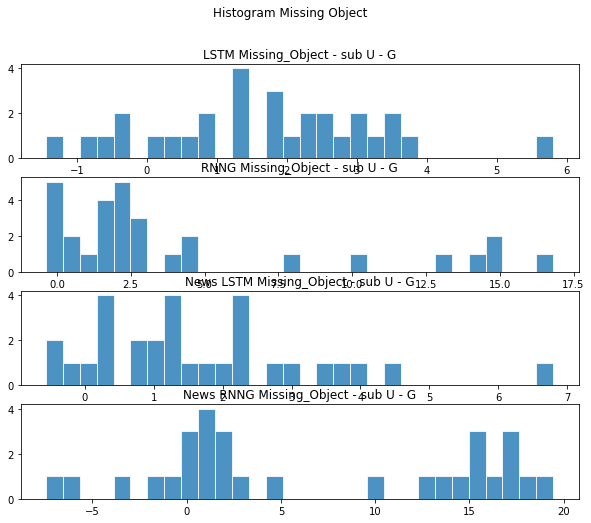

In [15]:
evaluate(test = 'Missing_Object' , modifier = 'sub',columns=2,annotate=True)

In [52]:
evaluate(test = 'Missing_Object' , modifier = 'sub2',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.800
rnng        0.800
large_lstm  0.767
large_rnng  0.733




,Ratio
lstm,0.800
rnng,0.800
large_lstm,0.767
large_rnng,0.733


           Ratio
lstm       0.800
rnng       0.800
news_lstm  0.900
news_rnng  0.733


0
1:  记者 采访 了 研发 产品 并且 获 了 奖 。 LSTM:  1.066 ; RNNG: 0.938 ; News LSTM:  0.544 ; News RNNG:  21.304 
2:  记者 采访 了 研发 产品 并且 获 了 奖 的 科学家 。 LSTM:  3.226 ; RNNG: 0.728 ; News LSTM:  1.661 ; News RNNG:  0.868
U - G:  LSTM:  -2.16 ; RNNG:  0.21 ; News LSTM:  -1.117 ; News RNNG:  20.436


1
1:  他 认识 了 写 书 并且 教 课 。 LSTM:  7.72 ; RNNG: 15.834 ; News LSTM:  2.288 ; News RNNG:  19.39 
2:  他 认识 了 写 书 并且 教 课 的 老师 。 LSTM:  4.966 ; RNNG: 1.641 ; News LSTM:  1.784 ; News RNNG:  3.713
U - G:  LSTM:  2.754 ; RNNG:  14.193 ; News LSTM:  0.504 ; News RNNG:  15.677


2
1:  他 拍 下 了 获得 大奖 并且 吸引 游客 。 LSTM:  2.898 ; RNNG: 0.905 ; News LSTM:  3.288 ; News RNNG:  4.561 
2:  他 拍 下 了 获得 大奖 并且 吸引 游客 的 艺术品 。 LSTM:  3.366 ; RNNG: 1.255 ; News LSTM:  2.028 ; News RNNG:  3.187
U - G:  LSTM:  -0.468 ; RNNG:  -0.35 ; News LSTM:  1.26 ; News RNNG:  1.374


3
1:  我们 参加 了 吸引 学生 并且 受到 好评 。 LSTM:  0.65 ; RNNG: 15.671 ; News LSTM:  0.665 ; New

,Ratio
lstm,0.800
rnng,0.800
news_lstm,0.900
news_rnng,0.733


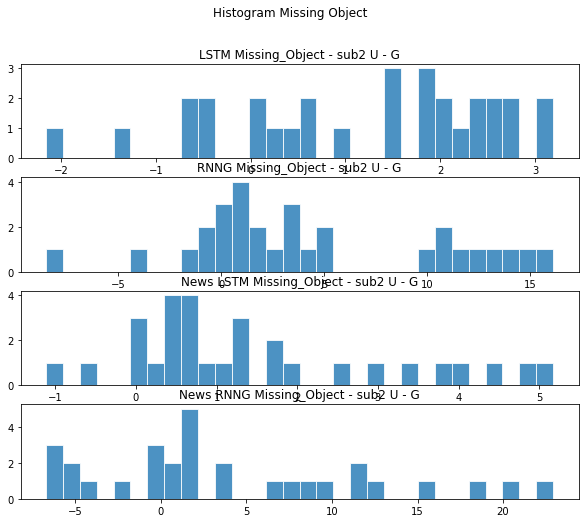

In [17]:
evaluate(test = 'Missing_Object' , modifier = 'sub2',columns=2,annotate=True)

In [53]:
evaluate(test = 'Missing_Object' , modifier = 'subh',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.667
rnng        0.700
large_lstm  0.600
large_rnng  0.600




,Ratio
lstm,0.667
rnng,0.700
large_lstm,0.600
large_rnng,0.600


           Ratio
lstm       0.667
rnng       0.700
news_lstm  0.700
news_rnng  0.600


0
1:  记者 采访 了 研发 帮助 老人 的 产品 。 LSTM:  1.916 ; RNNG: 1.167 ; News LSTM:  1.438 ; News RNNG:  0.893 
2:  记者 采访 了 研发 帮助 老人 的 产品 的 科学家 。 LSTM:  2.938 ; RNNG: 0.172 ; News LSTM:  1.835 ; News RNNG:  0.192
U - G:  LSTM:  -1.022 ; RNNG:  0.995 ; News LSTM:  -0.398 ; News RNNG:  0.701


1
1:  他 认识 了 写 介绍 名人 的 书 。 LSTM:  2.851 ; RNNG: 1.899 ; News LSTM:  1.45 ; News RNNG:  14.151 
2:  他 认识 了 写 介绍 名人 的 书 的 老师 。 LSTM:  2.658 ; RNNG: 5.545 ; News LSTM:  1.533 ; News RNNG:  3.241
U - G:  LSTM:  0.193 ; RNNG:  -3.647 ; News LSTM:  -0.083 ; News RNNG:  10.91


2
1:  他 拍 下 了 获得 代表 实力 的 大奖 。 LSTM:  1.791 ; RNNG: 0.192 ; News LSTM:  0.822 ; News RNNG:  2.337 
2:  他 拍 下 了 获得 代表 实力 的 大奖 的 艺术品 。 LSTM:  2.875 ; RNNG: 0.988 ; News LSTM:  1.482 ; News RNNG:  3.622
U - G:  LSTM:  -1.084 ; RNNG:  -0.796 ; News LSTM:  -0.66 ; News RNNG:  -1.284


3
1:  我们 参加 了 吸引 学习 历史 的 学生 。 LSTM:  2.642 ; RNNG: 3.527 ; News LSTM:  1.54 ; News

,Ratio
lstm,0.667
rnng,0.700
news_lstm,0.700
news_rnng,0.600


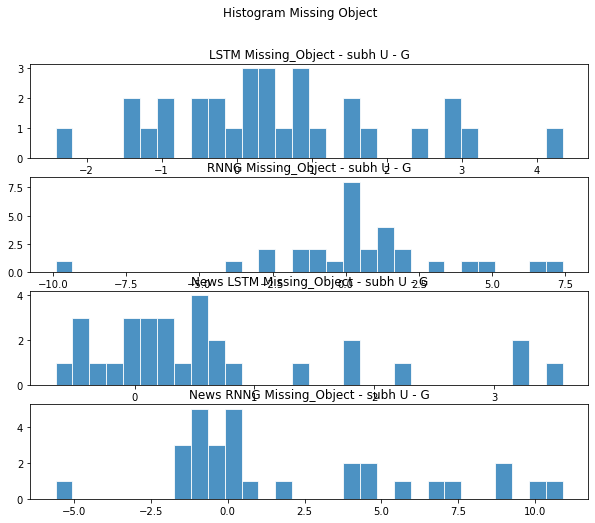

In [18]:
evaluate(test = 'Missing_Object' , modifier = 'subh',columns=2,annotate=True)

In [54]:
evaluate(test = 'Verb_Noun' , modifier = 'none',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.742
rnng        0.710
large_lstm  0.742
large_rnng  0.774




,Ratio
lstm,0.742
rnng,0.710
large_lstm,0.742
large_rnng,0.774


           Ratio
lstm       0.742
rnng       0.710
news_lstm  0.806
news_rnng  0.774


0
1:  那 位 教授 写 了 书 的 内容 。 LSTM:  9.19 ; RNNG: 11.409 ; News LSTM:  9.736 ; News RNNG:  13.248 
2:  那 位 教授 打 了 书 的 内容 。 LSTM:  9.475 ; RNNG: 13.896 ; News LSTM:  11.251 ; News RNNG:  12.529
U - G:  LSTM:  0.285 ; RNNG:  2.487 ; News LSTM:  1.515 ; News RNNG:  -0.72


1
1:  弟弟 启动 了 车 。 LSTM:  15.03 ; RNNG: 16.313 ; News LSTM:  18.592 ; News RNNG:  29.717 
2:  弟弟 认识 了 车 。 LSTM:  17.095 ; RNNG: 23.519 ; News LSTM:  19.351 ; News RNNG:  29.579
U - G:  LSTM:  2.065 ; RNNG:  7.206 ; News LSTM:  0.759 ; News RNNG:  -0.138


2
1:  他 拿 了 桌子 上 的 筷子 。 LSTM:  20.719 ; RNNG: 24.356 ; News LSTM:  16.221 ; News RNNG:  23.398 
2:  他 听 了 桌子 上 的 筷子 。 LSTM:  21.035 ; RNNG: 24.548 ; News LSTM:  17.298 ; News RNNG:  26.01
U - G:  LSTM:  0.316 ; RNNG:  0.192 ; News LSTM:  1.077 ; News RNNG:  2.611


3
1:  她 终于 实现 了 理想 。 LSTM:  21.269 ; RNNG: 21.842 ; News LSTM:  20.295 ; News RNNG:  17.008 
2:  她 终于 购买 了 理想 。 LSTM:  22.333

,Ratio
lstm,0.742
rnng,0.710
news_lstm,0.806
news_rnng,0.774


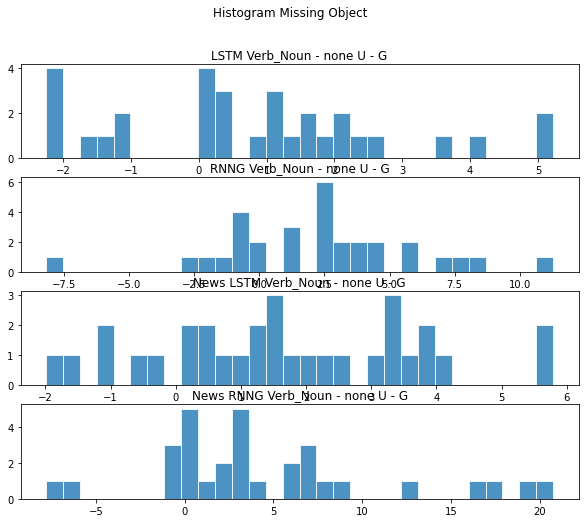

In [19]:
evaluate(test = 'Verb_Noun' , modifier = 'none',columns=2,annotate=True)

      Ratio
lstm  0.576
rnng  0.697




,Ratio
lstm,0.576
rnng,0.697


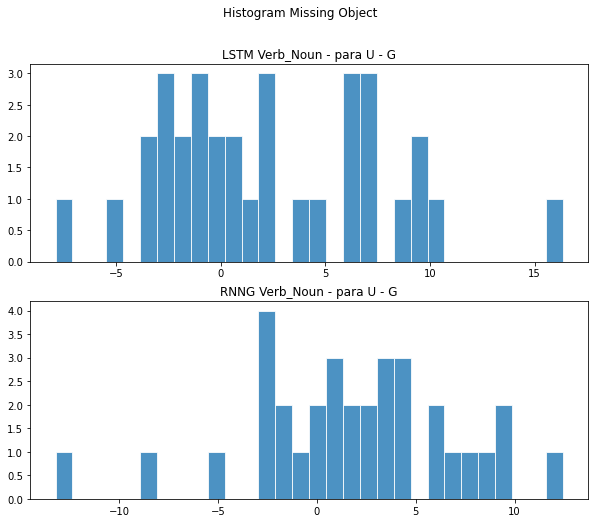

In [175]:
# evaluate(test = 'Verb_Noun' , modifier = 'para',columns=2,annotate=False)

      Ratio
lstm  0.606
rnng  0.545


0
1:  那 位 教授 写 了 书 。 LSTM:  13.724 ; RNNG: 17.239 
2:  那 位 教授 写 了 笔  。 LSTM:  27.855 ; RNNG: 21.586
U - G:  LSTM:  14.131 ; RNNG:  4.347


1
1:  弟弟 开 了 父亲 的 车 。 LSTM:  12.59 ; RNNG: 15.363 
2:  弟弟 开 了 父亲 的 钱 。 LSTM:  15.264 ; RNNG: 17.533
U - G:  LSTM:  2.674 ; RNNG:  2.17


2
1:  他 读 了 桌子 上 的 报纸 。 LSTM:  16.319 ; RNNG: 19.682 
2:  他 读 了 桌子 上 的 筷子 。 LSTM:  19.613 ; RNNG: 21.251
U - G:  LSTM:  3.294 ; RNNG:  1.569


3
1:  她 终于 实现 了 她 的 理想 。 LSTM:  12.991 ; RNNG: 15.152 
2:  她 终于 实现 了 她 的 手机 。 LSTM:  13.204 ; RNNG: 13.699
U - G:  LSTM:  0.213 ; RNNG:  -1.453


4
1:  我 修理 了 这个 电脑 。 LSTM:  14.022 ; RNNG: 13.928 
2:  我 修理 了 这个 想法 。 LSTM:  15.446 ; RNNG: 11.33
U - G:  LSTM:  1.424 ; RNNG:  -2.598


5
1:  他 承担 了 我 的 责任 。 LSTM:  12.778 ; RNNG: 8.528 
2:  他 承担 了 我 的 学校 。 LSTM:  15.579 ; RNNG: 15.824
U - G:  LSTM:  2.801 ; RNNG:  7.296


6
1:  我 邀请 过 我 的 朋友 。 LSTM:  8.544 ; RNNG: 9.968 
2:  我 邀请 过 我 的 音响 。 LSTM:  20.766 ; RNNG: 26.911
U - G:  LSTM:  12.222 ;

,Ratio
lstm,0.606
rnng,0.545


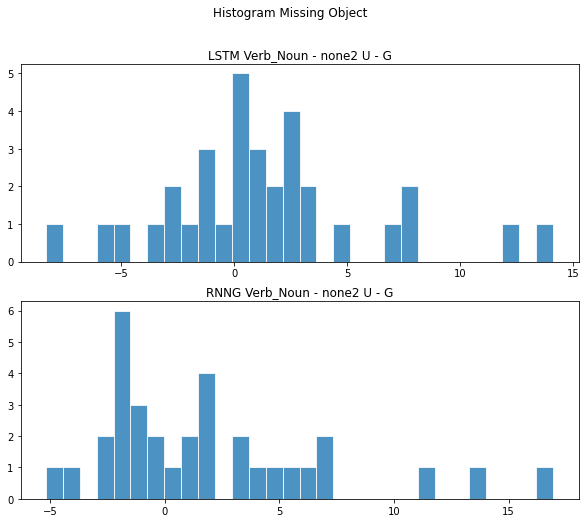

In [156]:
# evaluate(test = 'Verb_Noun' , modifier = 'none2',columns=2,annotate=True)

In [55]:
evaluate(test = 'Verb_Noun' , modifier = 'adj',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.645
rnng        0.710
large_lstm  0.645
large_rnng  0.645




,Ratio
lstm,0.645
rnng,0.710
large_lstm,0.645
large_rnng,0.645


           Ratio
lstm       0.645
rnng       0.710
news_lstm  0.871
news_rnng  0.645




,Ratio
lstm,0.645
rnng,0.710
news_lstm,0.871
news_rnng,0.645


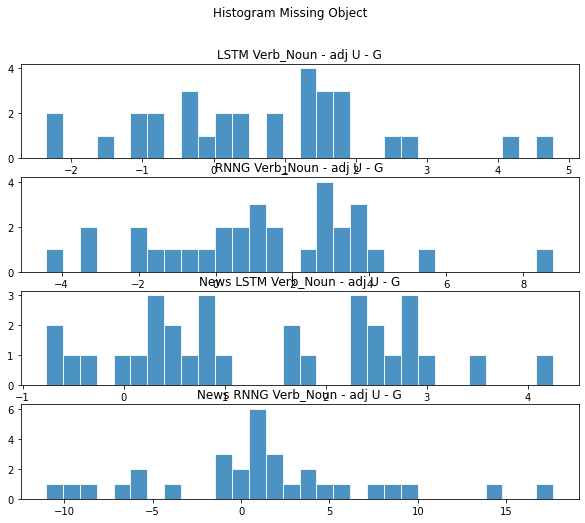

In [20]:
evaluate(test = 'Verb_Noun' , modifier = 'adj',columns=2,annotate=False)

In [56]:
evaluate(test = 'Verb_Noun' , modifier = 'obj',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.677
rnng        0.774
large_lstm  0.581
large_rnng  0.645




,Ratio
lstm,0.677
rnng,0.774
large_lstm,0.581
large_rnng,0.645


           Ratio
lstm       0.677
rnng       0.774
news_lstm  0.774
news_rnng  0.645




,Ratio
lstm,0.677
rnng,0.774
news_lstm,0.774
news_rnng,0.645


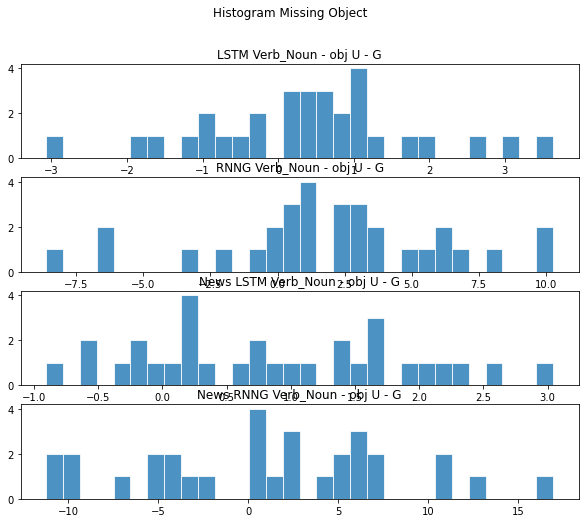

In [21]:
evaluate(test = 'Verb_Noun' , modifier = 'obj',columns=2,annotate=False)

In [57]:
evaluate(test = 'Verb_Noun' , modifier = 'sub',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.613
rnng        0.677
large_lstm  0.613
large_rnng  0.645




,Ratio
lstm,0.613
rnng,0.677
large_lstm,0.613
large_rnng,0.645


           Ratio
lstm       0.613
rnng       0.677
news_lstm  0.710
news_rnng  0.645




,Ratio
lstm,0.613
rnng,0.677
news_lstm,0.710
news_rnng,0.645


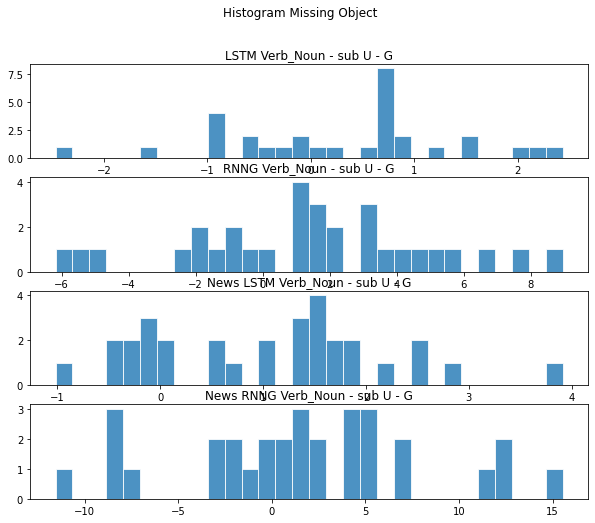

In [22]:
evaluate(test = 'Verb_Noun' , modifier = 'sub',columns=2,annotate=False)

In [58]:
evaluate(test = 'Subordination' , modifier = 'none',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.800
rnng        0.900
large_lstm  0.867
large_rnng  0.933




,Ratio
lstm,0.800
rnng,0.900
large_lstm,0.867
large_rnng,0.933


           Ratio
lstm       0.800
rnng       0.900
news_lstm  0.900
news_rnng  0.933


0
1:  随着 政府 发展 ， 经济 变 好 了 。 LSTM:  2.484 ; RNNG: 1.622 ; News LSTM:  1.697 ; News RNNG:  2.785 
2:  随着 政府 发展 。 LSTM:  6.859 ; RNNG: 13.832 ; News LSTM:  8.965 ; News RNNG:  19.78
U - G:  LSTM:  4.375 ; RNNG:  12.211 ; News LSTM:  7.268 ; News RNNG:  16.995


1
1:  随着 互联网 的 出现 ， 生活 质量 提高 了 。 LSTM:  5.62 ; RNNG: 8.966 ; News LSTM:  2.122 ; News RNNG:  2.63 
2:  随着 互联网 的 出现 。 LSTM:  5.37 ; RNNG: 9.861 ; News LSTM:  9.552 ; News RNNG:  17.722
U - G:  LSTM:  -0.25 ; RNNG:  0.896 ; News LSTM:  7.43 ; News RNNG:  15.092


2
1:  随着 一阵 铃声 ， 火车 开 了 。 LSTM:  8.637 ; RNNG: 9.992 ; News LSTM:  6.215 ; News RNNG:  17.776 
2:  随着 一阵 铃声 。 LSTM:  7.356 ; RNNG: 13.168 ; News LSTM:  9.258 ; News RNNG:  17.81
U - G:  LSTM:  -1.282 ; RNNG:  3.176 ; News LSTM:  3.044 ; News RNNG:  0.034


3
1:  随着 他 的 年龄 增长 ， 他 更 有 自信 了 。 LSTM:  1.742 ; RNNG: 0.105 ; News LSTM:  5.405 ; News RNNG:  0.707 
2:  随着 他 的 年龄 增长 。 LSTM:  4.583 ;

,Ratio
lstm,0.800
rnng,0.900
news_lstm,0.900
news_rnng,0.933


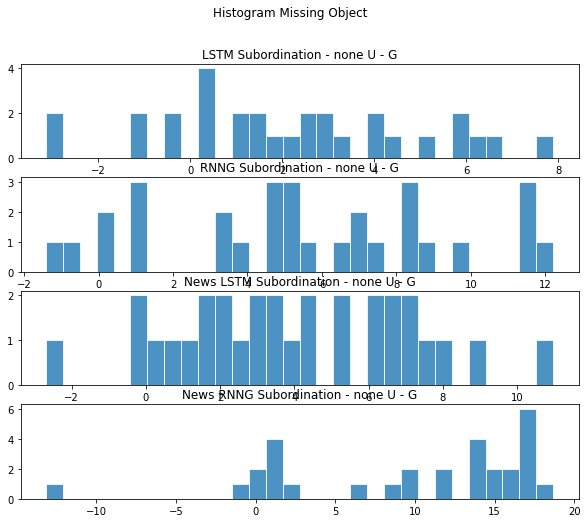

In [23]:
evaluate(test = 'Subordination' , modifier = 'none',columns=2,annotate=True)

In [59]:
evaluate(test = 'Subordination' , modifier = 'adj',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.800
rnng        0.867
large_lstm  0.767
large_rnng  0.833




,Ratio
lstm,0.800
rnng,0.867
large_lstm,0.767
large_rnng,0.833


           Ratio
lstm       0.800
rnng       0.867
news_lstm  0.867
news_rnng  0.833




,Ratio
lstm,0.800
rnng,0.867
news_lstm,0.867
news_rnng,0.833


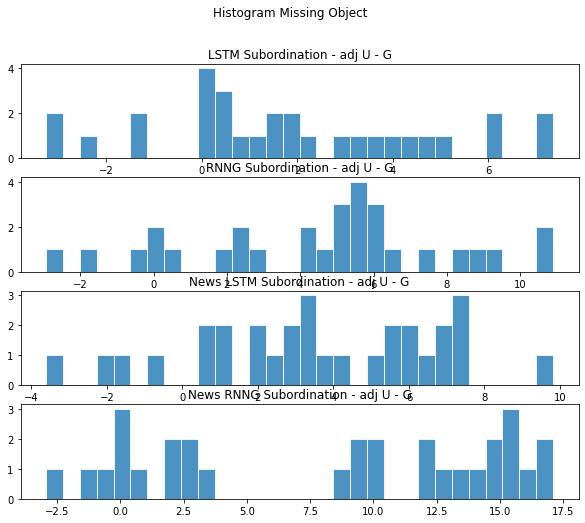

In [24]:
evaluate(test = 'Subordination' , modifier = 'adj',columns=2,annotate=False)

In [60]:
evaluate(test = 'Subordination' , modifier = 'obj',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.767
rnng        0.933
large_lstm  0.800
large_rnng  0.833




,Ratio
lstm,0.767
rnng,0.933
large_lstm,0.800
large_rnng,0.833


           Ratio
lstm       0.767
rnng       0.933
news_lstm  0.833
news_rnng  0.833




,Ratio
lstm,0.767
rnng,0.933
news_lstm,0.833
news_rnng,0.833


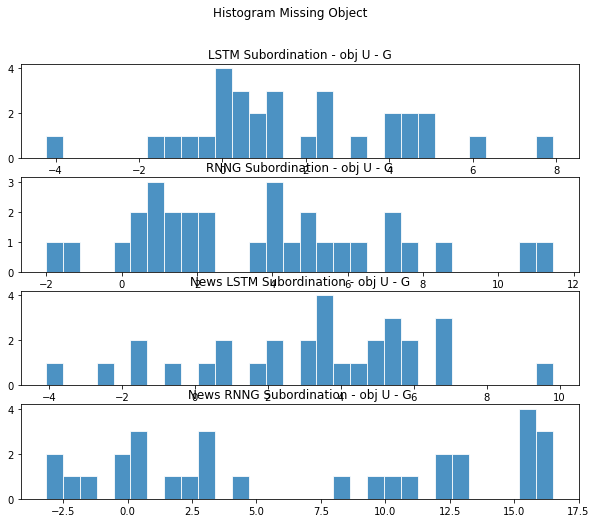

In [25]:
evaluate(test = 'Subordination' , modifier = 'obj',columns=2,annotate=False)

In [61]:
evaluate(test = 'Subordination' , modifier = 'sub',columns=2,annotate=False,plot=False)

            Ratio
lstm        0.733
rnng        0.700
large_lstm  0.800
large_rnng  0.800




,Ratio
lstm,0.733
rnng,0.700
large_lstm,0.800
large_rnng,0.800


           Ratio
lstm       0.733
rnng       0.700
news_lstm  0.867
news_rnng  0.800




,Ratio
lstm,0.733
rnng,0.700
news_lstm,0.867
news_rnng,0.800


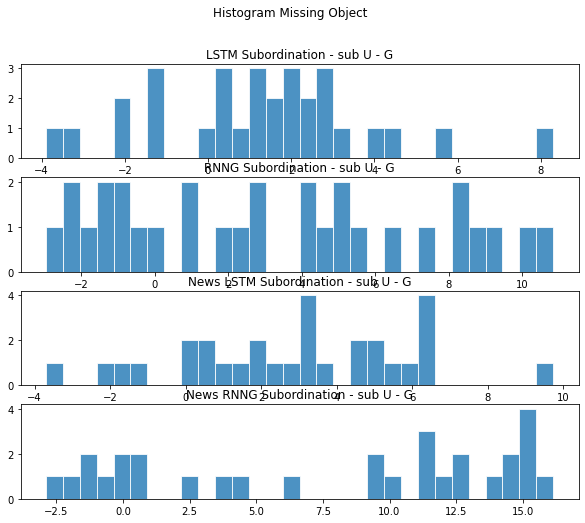

In [26]:
evaluate(test = 'Subordination' , modifier = 'sub',columns=2,annotate=False)

## Classifier

In [3]:
path = "results/Classifier/"
rnng_path = "../OpenMind/outputs/"

In [4]:
surp_none_lstm = pd.read_csv(path + 'surprisals_none.tsv', sep='\t', header=0)
surp_none_rnng = pd.read_table(rnng_path + 'surprisals_output_none.txt', header=0)
sent_none = pd.read_table("test_suites/Classifier/cls_none_txt.txt",header=None)
surp_adj_lstm = pd.read_csv(path + 'surprisals_adj.tsv', sep='\t', header=0)
sent_adj = pd.read_table("test_suites/Classifier/cls_adj_txt.txt",header=None)
assert len(surp_none_lstm) == len(surp_none_rnng)

In [5]:
max(surp_none_lstm['sentence_id'])/4

30.0

In [6]:
surp_none_lstm

,sentence_id,token_id,token,surprisal
0,1,1,我,6.978171
1,1,2,很,6.768952
2,1,3,喜欢,4.918214
3,1,4,一,5.979936
4,1,5,位,4.502104
...,...,...,...,...
847,120,2,有,5.617175
848,120,3,一,2.186593
849,120,4,支,5.463740
850,120,5,渔船,12.524443


In [38]:
none_df_lstm = pd.DataFrame(data=surprisal_by_tests(surp_none_lstm),columns=['G1','U1','G2','U2'])
none_df_rnng = pd.DataFrame(data=surprisal_by_tests(surp_none_rnng),columns=['G1','U1','G2','U2'])
adj_df_lstm = pd.DataFrame(data=surprisal_by_tests(surp_adj_lstm),columns=['G1','U1','G2','U2'])

In [39]:
# none
first_noun_lstm = none_df_lstm['U1'] - none_df_lstm['G1'] 
second_noun_lstm = none_df_lstm['U2'] - none_df_lstm['G2'] 
first_class_lstm = none_df_lstm['U2'] - none_df_lstm['G1'] 
second_class_lstm = none_df_lstm['U1'] - none_df_lstm['G2'] 

first_noun_rnng = none_df_rnng['U1'] - none_df_rnng['G1'] 
second_noun_rnng = none_df_rnng['U2'] - none_df_rnng['G2'] 
first_class_rnng = none_df_rnng['U2'] - none_df_rnng['G1'] 
second_class_rnng = none_df_rnng['U1'] - none_df_rnng['G2'] 

# adj
# first_adj_lstm = adj_df_lstm['U1'] - adj_df_lstm['G1'] 
# second_adj_lstm = adj_df_lstm['U2'] - adj_df_lstm['G2'] 
# first_class_lstm = adj_df_lstm['U2'] - adj_df_lstm['G1'] 
# second_class_lstm = adj_df_lstm['U1'] - adj_df_lstm['G2'] 

In [14]:
# assert first_adj_lstm.mean() > 0 , "First Noun - Classifier Pair fails a lot"
# assert second_adj_lstm.mean() > 0 , "Second Noun - Classifier Pair fails a lot"
# assert first_class_lstm.mean() > 0 , "First Classifier - Noun Pair fails a lot"
# assert second_class_lstm.mean() > 0 , "Second Classifier - Noun Pair fails a lot"

Text(0.5, 0.98, 'LSTM Classifier - None')

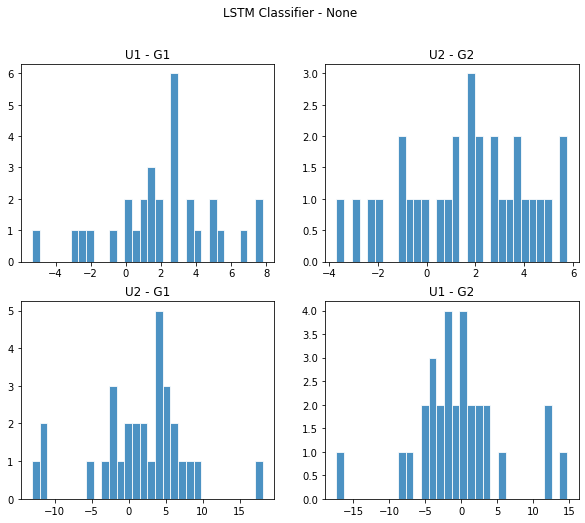

In [15]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
ax[0][0].hist(first_noun_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[0][0].set_title('U1 - G1')
ax[0][1].hist(second_noun_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[0][1].set_title('U2 - G2')
ax[1][0].hist(first_class_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[1][0].set_title('U2 - G1')
ax[1][1].hist(second_class_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[1][1].set_title('U1 - G2')
fig.suptitle('LSTM Classifier - None')

Text(0.5, 0.98, 'RNNG Classifier - None')

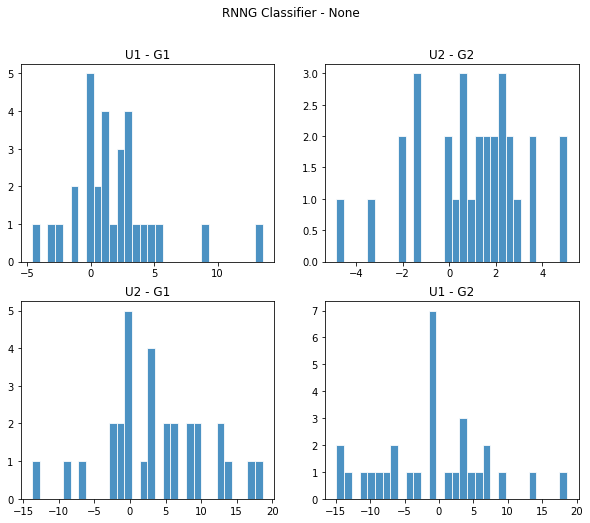

In [16]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
ax[0][0].hist(first_noun_rnng,alpha= 0.8,bins=30,edgecolor='white')
ax[0][0].set_title('U1 - G1')
ax[0][1].hist(second_noun_rnng,alpha= 0.8,bins=30,edgecolor='white')
ax[0][1].set_title('U2 - G2')
ax[1][0].hist(first_class_rnng,alpha= 0.8,bins=30,edgecolor='white')
ax[1][0].set_title('U2 - G1')
ax[1][1].hist(second_class_rnng,alpha= 0.8,bins=30,edgecolor='white')
ax[1][1].set_title('U1 - G2')
fig.suptitle('RNNG Classifier - None')

In [20]:
sum(first_noun_rnng>0)/len(first_noun_rnng)

0.7333333333333333

In [41]:
lstm_cls_first_noun = calc_accuracy(first_noun_lstm)
lstm_cls_second_noun = calc_accuracy(second_noun_lstm)
lstm_cls_first_class = calc_accuracy(first_class_lstm)
lstm_cls_second_class = calc_accuracy(second_class_lstm)
lstm_total = np.mean([lstm_cls_first_noun,lstm_cls_second_noun,lstm_cls_first_class,lstm_cls_second_class])

rnng_cls_first_noun = calc_accuracy(first_noun_rnng)
rnng_cls_second_noun = calc_accuracy(second_noun_rnng)
rnng_cls_first_class = calc_accuracy(first_class_rnng)
rnng_cls_second_class = calc_accuracy(second_class_rnng)
rnng_total = np.mean([rnng_cls_first_noun,rnng_cls_second_noun,rnng_cls_first_class,rnng_cls_second_class])


In [42]:
data = [[np.round(lstm_cls_first_noun,3),np.round(lstm_cls_second_noun,3),np.round(lstm_cls_first_class,3),np.round(lstm_cls_second_class,3),np.round(lstm_total,3)],
       [np.round(rnng_cls_first_noun,3),np.round(rnng_cls_second_noun,3),np.round(rnng_cls_first_class,3),np.round(rnng_cls_second_class,3),np.round(rnng_total,3)]]
table = pd.DataFrame(data)
table.index = ['lstm','rnng']
table.columns = ['First noun', 'Second noun', 'First classifier', 'Second classifier', 'Total']
table

,First noun,Second noun,First classifier,Second classifier,Total
lstm,0.800,0.733,0.667,0.567,0.692
rnng,0.733,0.733,0.633,0.400,0.625


In [44]:
for i in range(len(first_noun_lstm)):
    print(i)
    print('1: ', sent_none.loc[i*4].values[0], 'LSTM: ', round(none_df_lstm['G1'].loc[i],3), '; RNNG: ',  round(none_df_rnng['G1'].loc[i],3), 
          '\n2: ', sent_none.loc[1+i*4].values[0], 'LSTM: ', round(none_df_lstm['U1'].loc[i],3), '; RNNG: ',  round(none_df_rnng['U1'].loc[i],3),
          '\n3: ',sent_none.loc[2+i*4].values[0], 'LSTM: ', round(none_df_lstm['G2'].loc[i],3), '; RNNG: ', round(none_df_rnng['G2'].loc[i],3),
          '\n4: ',sent_none.loc[3+i*4].values[0], 'LSTM: ', round(none_df_lstm['U2'].loc[i],3), '; RNNG: ', round(none_df_rnng['U2'].loc[i],3))
    print('2 - 1: ', 'LSTM: ', round(first_noun_lstm[i],3), '; RNNG: ', round(first_noun_rnng[i],3))
    print('4 - 3: ', 'LSTM: ', round(second_noun_lstm[i],3), '; RNNG: ', round(second_noun_rnng[i],3))
    print('4 - 1: ', 'LSTM: ', round(first_class_lstm[i],3),'; RNNG: ', round(first_class_rnng[i],3))
    print('2 - 3: ', 'LSTM: ', round(second_class_lstm[i],3), '; RNNG: ', round(second_class_rnng[i],3))
    print('\n')
    

0
1:  我 很 喜欢 一 位 明星 。 LSTM:  16.537 ; RNNG:  14.707 
2:  我 很 喜欢 一 首 明星 。 LSTM:  19.467 ; RNNG:  18.446 
3:  我 很 喜欢 一 首 歌曲 。 LSTM:  16.786 ; RNNG:  15.416 
4:  我 很 喜欢 一 位 歌曲 。 LSTM:  22.33 ; RNNG:  17.136
2 - 1:  LSTM:  2.93 ; RNNG:  3.739
4 - 3:  LSTM:  5.544 ; RNNG:  1.72
4 - 1:  LSTM:  5.793 ; RNNG:  2.429
2 - 3:  LSTM:  2.681 ; RNNG:  3.03


1
1:  她 开车 去 了 一 家 店 。 LSTM:  15.091 ; RNNG:  10.552 
2:  她 开车 去 了 一 座 店 。 LSTM:  16.435 ; RNNG:  11.898 
3:  她 开车 去 了 一 座 山 。 LSTM:  16.965 ; RNNG:  12.355 
4:  她 开车 去 了 一 家 山 。 LSTM:  19.771 ; RNNG:  13.037
2 - 1:  LSTM:  1.344 ; RNNG:  1.346
4 - 3:  LSTM:  2.806 ; RNNG:  0.682
4 - 1:  LSTM:  4.68 ; RNNG:  2.485
2 - 3:  LSTM:  -0.53 ; RNNG:  -0.458


2
1:  他 有 一 双 手套 。 LSTM:  23.613 ; RNNG:  17.532 
2:  他 有 一 枚 手套 。 LSTM:  21.409 ; RNNG:  17.599 
3:  他 有 一 枚 纽扣 。 LSTM:  20.831 ; RNNG:  22.19 
4:  他 有 一 双 纽扣 。 LSTM:  22.745 ; RNNG:  24.291
2 - 1:  LSTM:  -2.204 ; RNNG:  0.067
4 - 3:  LSTM:  1.914 ; RNNG:  2.1
4 - 1:  LSTM:  -0.868 ; RNNG:  6.75

RNNG seems to perform a bit better than the LSTM when looking at the same noun different classifier comparisons. However, it performs even worse than the LSTM in cross-noun comparisons.

## Missing Object

In [44]:
surp_none_rnng_mo

,sentence_id,token_id,token,surprisal
0,1,1,记者,10.20740
1,1,2,采访,8.35926
2,1,3,了,4.34739
3,1,4,。,11.92810
4,2,1,记者,10.20740
...,...,...,...,...
301,68,1,我,6.05420
302,68,2,经常,9.21412
303,68,3,去,6.33960
304,68,4,医院,8.84087


In [45]:
path = "results/Missing_Object/"
rnng_path = "../OpenMind/outputs/"
surp_none_lstm_mo = pd.read_csv(path + 'surprisals_mobj_none.tsv', sep='\t', header=0)
surp_none_rnng_mo = pd.read_table(rnng_path + 'surprisals_output_mobj_none.txt', header=0)
sent_none_mo = pd.read_table("test_suites/Missing_Object/mobj_none_txt.txt",header=None)
surp_sub_lstm_mo = pd.read_csv(path + 'surprisals_mobj_sub.tsv', sep='\t', header=0)
surp_sub_rnng_mo = pd.read_table(rnng_path + 'surprisals_output_mobj_sub.txt',header=0)
sent_sub_mo = pd.read_table("test_suites/Missing_Object/mobj_sub_txt.txt",header=None)

In [46]:
none_df_lstm_mo = pd.DataFrame(data=surprisal_by_tests(surp_none_lstm_mo,columns=2,target=-1),columns=['U','G'])
none_df_rnng_mo = pd.DataFrame(data=surprisal_by_tests(surp_none_rnng_mo,columns=2,target=-1),columns=['U','G'])
sub_df_lstm_mo = pd.DataFrame(data=surprisal_by_tests(surp_sub_lstm_mo,columns=2,target=-1),columns=['U','G'])
sub_df_rnng_mo = pd.DataFrame(data=surprisal_by_tests(surp_sub_rnng_mo,columns=2,target=-1),columns=['U','G'])

In [47]:
diff_mobj_none = none_df_lstm_mo['U'] - none_df_lstm_mo['G'] 
diff_mobj_sub = sub_df_lstm_mo['U'] - sub_df_lstm_mo['G'] 
print('LSTM None: ', np.mean(diff_mobj_none),'; Sub: ',np.mean(diff_mobj_sub))

LSTM None:  2.9777296281629995 ; Sub:  1.7310549751404793


In [48]:
diff_mobj_none_rnng = none_df_rnng_mo['U'] - none_df_rnng_mo['G'] 
diff_mobj_sub_rnng = sub_df_rnng_mo['U'] - sub_df_rnng_mo['G'] 
print('RNNG None: ', np.mean(diff_mobj_none_rnng),'; Sub: ',np.mean(diff_mobj_sub_rnng))

RNNG None:  4.664995294117648 ; Sub:  4.726602882352942


Text(0.5, 0.98, 'Missing Object')

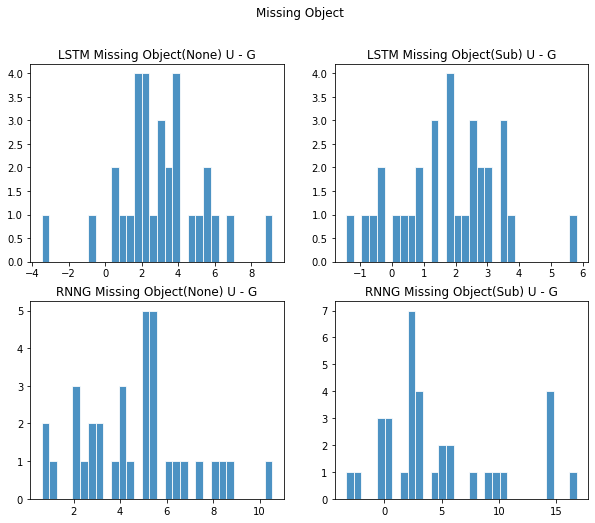

In [49]:
fig, ax = plt.subplots(2,2,figsize=(10,8))
ax[0][0].hist(diff_mobj_none,alpha= 0.8,bins=30,edgecolor='white')
ax[0][0].set_title('LSTM Missing Object(None) U - G')
ax[0][1].hist(diff_mobj_sub,alpha= 0.8,bins=30,edgecolor='white')
ax[0][1].set_title('LSTM Missing Object(Sub) U - G')
ax[1][0].hist(diff_mobj_none_rnng,alpha= 0.8,bins=30,edgecolor='white')
ax[1][0].set_title('RNNG Missing Object(None) U - G')
ax[1][1].hist(diff_mobj_sub_rnng,alpha= 0.8,bins=30,edgecolor='white')
ax[1][1].set_title('RNNG Missing Object(Sub) U - G')
fig.suptitle('Missing Object')

In [51]:
for i in range(len(diff_mobj_none)):
    print(i)
    print('1: ', sent_none_mo.loc[i*2].values[0], 'LSTM: ',round(none_df_lstm_mo['U'].loc[i],3),'; RNNG:',round(none_df_rnng_mo['U'].loc[i],3),
          '\n2: ', sent_none_mo.loc[1+i*2].values[0],'LSTM: ', round(none_df_lstm_mo['G'].loc[i],3),'; RNNG:',round(none_df_rnng_mo['G'].loc[i],3))
    print('U - G: ', 'LSTM: ', round(diff_mobj_none[i],3),'; RNNG: ', round(diff_mobj_none_rnng[i],3))
    print('\n')

0
1:  记者 采访 了 。 LSTM:  3.444 ; RNNG: 11.928 
2:  记者 采访 了 科学家 。 LSTM:  6.915 ; RNNG: 1.382
U - G:  LSTM:  -3.471 ; RNNG:  10.546


1
1:  他 拿出 了 。 LSTM:  8.821 ; RNNG: 15.773 
2:  他 拿出 了 篮子 。 LSTM:  8.18 ; RNNG: 7.306
U - G:  LSTM:  0.641 ; RNNG:  8.467


2
1:  他 认识 了 。 LSTM:  7.358 ; RNNG: 10.378 
2:  他 认识 了 老师 。 LSTM:  4.284 ; RNNG: 3.775
U - G:  LSTM:  3.074 ; RNNG:  6.603


3
1:  他 拍 下 了 。 LSTM:  7.493 ; RNNG: 4.844 
2:  他 拍 下 了 艺术品 。 LSTM:  4.979 ; RNNG: 3.552
U - G:  LSTM:  2.514 ; RNNG:  1.292


4
1:  我们 参加 了 。 LSTM:  8.314 ; RNNG: 9.818 
2:  我们 参加 了 活动 。 LSTM:  2.221 ; RNNG: 1.026
U - G:  LSTM:  6.094 ; RNNG:  8.792


5
1:  他 想起 了 。 LSTM:  10.207 ; RNNG: 10.812 
2:  他 想起 了 同学 。 LSTM:  5.259 ; RNNG: 5.726
U - G:  LSTM:  4.949 ; RNNG:  5.087


6
1:  司机 启动 了 。 LSTM:  3.668 ; RNNG: 6.981 
2:  司机 启动 了 车 。 LSTM:  4.291 ; RNNG: 3.228
U - G:  LSTM:  -0.623 ; RNNG:  3.752


7
1:  爸爸 买 了 。 LSTM:  6.997 ; RNNG: 4.883 
2:  爸爸 买 了 房子 。 LSTM:  4.794 ; RNNG: 2.356
U - G:  LSTM:  2.203 ; RNNG:  

Both LSTM and RNNG work better than in the Classifier case. On top of that, RNNG works extremely better with all positive results as expected.

In [53]:
for i in range(len(diff_mobj_none)):
    print(i)
    print('1: ', sent_sub_mo.loc[i*2].values[0], 'LSTM: ',round(sub_df_lstm_mo['U'].loc[i],3),'; RNNG:',round(sub_df_rnng_mo['U'].loc[i],3),
          '\n2: ', sent_sub_mo.loc[1+i*2].values[0],'LSTM: ', round(sub_df_lstm_mo['G'].loc[i],3),'; RNNG:',round(sub_df_rnng_mo['G'].loc[i],3))
    print('U - G: ', 'LSTM: ', round(diff_mobj_sub[i],3),'; RNNG: ', round(diff_mobj_sub_rnng[i],3))
    print('\n')

0
1:  记者 采访 了 研发 产品 。 LSTM:  4.952 ; RNNG: 3.258 
2:  记者 采访 了 研发 产品 的 科学家 。 LSTM:  4.069 ; RNNG: 0.644
U - G:  LSTM:  0.883 ; RNNG:  2.613


1
1:  他 拿出 了 有 苹果 。 LSTM:  9.398 ; RNNG: 15.068 
2:  他 拿出 了 有 苹果 的 篮子 。 LSTM:  6.525 ; RNNG: 11.77
U - G:  LSTM:  2.873 ; RNNG:  3.298


2
1:  他 认识 了 写 书 。 LSTM:  5.857 ; RNNG: 9.67 
2:  他 认识 了 写 书 的 老师 。 LSTM:  4.146 ; RNNG: 1.995
U - G:  LSTM:  1.711 ; RNNG:  7.675


3
1:  他 拍 下 了 获得 大奖 。 LSTM:  3.444 ; RNNG: 0.313 
2:  他 拍 下 了 获得 大奖 的 艺术品 。 LSTM:  3.861 ; RNNG: 0.236
U - G:  LSTM:  -0.417 ; RNNG:  0.077


4
1:  我们 参加 了 吸引 学生 。 LSTM:  5.49 ; RNNG: 15.464 
2:  我们 参加 了 吸引 学生 的 活动 。 LSTM:  2.532 ; RNNG: 0.899
U - G:  LSTM:  2.958 ; RNNG:  14.565


5
1:  他 想起 了 写 过 歌 。 LSTM:  6.072 ; RNNG: 4.228 
2:  他 想起 了 写 过 歌 的 同学 。 LSTM:  2.585 ; RNNG: 2.002
U - G:  LSTM:  3.487 ; RNNG:  2.225


6
1:  司机 启动 了 装有 音响 。 LSTM:  8.866 ; RNNG: 20.093 
2:  司机 启动 了 装有 音响 的 车 。 LSTM:  3.057 ; RNNG: 3.281
U - G:  LSTM:  5.809 ; RNNG:  16.812


7
1:  爸爸 买 了 带 家具 。 LSTM:  

Both the RNNG and LSTM model's performances suffer a bit when a subject extracted clause is embedded after the main verb. For test suites that RNNG produces negative diff, maybe double-check if the sub-clause makes sense with the selected noun?

In [55]:
for i in range(len(first_adj_lstm)):
    print(i)
    print('1: ', sent_adj.loc[i*4].values[0], round(adj_df_lstm['G1'].loc[i],3),  '\n2: ', sent_adj.loc[1+i*4].values[0], round(adj_df_lstm['U1'].loc[i],3), '\n3: ',sent_adj.loc[2+i*4].values[0], 
          round(adj_df_lstm['G2'].loc[i],3), '\n4: ',sent_adj.loc[3+i*4].values[0], round(adj_df_lstm['U2'].loc[i],3))
    print('2 - 1: ', round(first_adj_lstm[i],3))
    print('4 - 3: ', round(second_adj_lstm[i],3))
    print('4 - 1: ', round(first_class_lstm[i],3))
    print('2 - 3: ', round(second_class_lstm[i],3))
    print('\n')

0
1:  我 很 喜欢 一 位 国内 的 明星 。 14.229 
2:  我 很 喜欢 一 首 国内 的 明星 。 14.754 
3:  我 很 喜欢 一 首 国内 的 歌曲 。 20.052 
4:  我 很 喜欢 一 位 国内 的 歌曲 。 21.548
2 - 1:  0.525
4 - 3:  1.496
4 - 1:  5.793
2 - 3:  2.681


1
1:  她 开车 去 了 一 家 郊外 的 店 。 16.248 
2:  她 开车 去 了 一 座 郊外 的 店 。 16.226 
3:  她 开车 去 了 一 座 郊外 的 山 。 17.669 
4:  她 开车 去 了 一 家 郊外 的 山 。 17.896
2 - 1:  -0.022
4 - 3:  0.227
4 - 1:  4.68
2 - 3:  -0.53


2
1:  他 有 一 双 蓝色 的 手套 。 23.35 
2:  他 有 一 枚 蓝色 的 手套 。 21.792 
3:  他 有 一 枚 蓝色 的 纽扣 。 25.249 
4:  他 有 一 双 蓝色 的 纽扣 。 24.954
2 - 1:  -1.559
4 - 3:  -0.294
4 - 1:  -0.868
2 - 3:  0.577


3
1:  店长 拿 着 一 只 便宜 的 兔子 。 27.101 
2:  店长 拿 着 一 根 便宜 的 兔子 。 26.597 
3:  店长 拿 着 一 根 便宜 的 萝卜 。 26.192 
4:  店长 拿 着 一 只 便宜 的 萝卜 。 28.228
2 - 1:  -0.503
4 - 3:  2.037
4 - 1:  1.11
2 - 3:  -1.854


4
1:  他 认识 了 一 名 幸运 的 男孩 。 16.713 
2:  他 认识 了 一 本 幸运 的 男孩 。 18.772 
3:  他 认识 了 一 本 幸运 的 小说 。 13.094 
4:  他 认识 了 一 名 幸运 的 小说 。 11.677
2 - 1:  2.06
4 - 3:  -1.418
4 - 1:  -3.597
2 - 3:  3.491


5
1:  男人 在 扫描 一 篇 很 短 的 文章 。 11.029 
2:  男人 在 扫描 

Text(0.5, 1.0, 'U1 - G2')

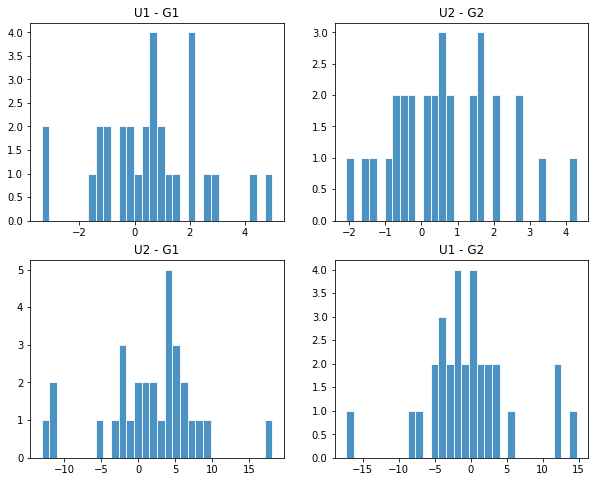

In [132]:
fig,ax = plt.subplots(2,2,figsize=(10,8))
ax[0][0].hist(first_adj_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[0][0].set_title('U1 - G1')
ax[0][1].hist(second_adj_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[0][1].set_title('U2 - G2')
ax[1][0].hist(lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[1][0].set_title('U2 - G1')
ax[1][1].hist(second_class_lstm,alpha= 0.8,bins=30,edgecolor='white')
ax[1][1].set_title('U1 - G2')